In [1]:
import warnings
warnings.filterwarnings('ignore')
import random
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import probplot, kurtosis, skew, gmean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomTreesEmbedding

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Activation, GaussianNoise
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## Tabular Playground Series - Jan 2021

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-jan-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-jan-2021/test.csv')

continuous_features = [feature for feature in df_train.columns if feature.startswith('cont')]
target = 'target'

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape = (300000, 16)
Training Set Memory Usage = 36.62 MB
Test Set Shape = (200000, 15)
Test Set Memory Usage = 22.89 MB


## 1. Target

`target` is the name of target feature. It follows an extremely left tailed bimodal distribution. Target mean and median are very close to each other because there are very few outliers which can be seen from the probability plot. Those two outliers are 0 and 3.7, and they should be dealt with.

Bimodal distribution can be break into two components with gaussian mixture model, but it is not possible to predict components of test set. At best, it can be done with 61% accuracy, which leads models to predict `target` closer to mean of two components in both training and test set. 

Target feature target Statistical Analysis
------------------------------------------
Mean: 7.906  -  Median: 7.941  -  Std: 0.7331
Min: 0.0  -  25%: 7.329  -  50%: 7.941  -  75%: 8.47  -  Max: 10.27
Skew: -0.0774  -  Kurtosis: -0.4826
Missing Values: 0/300000 (0.0%)


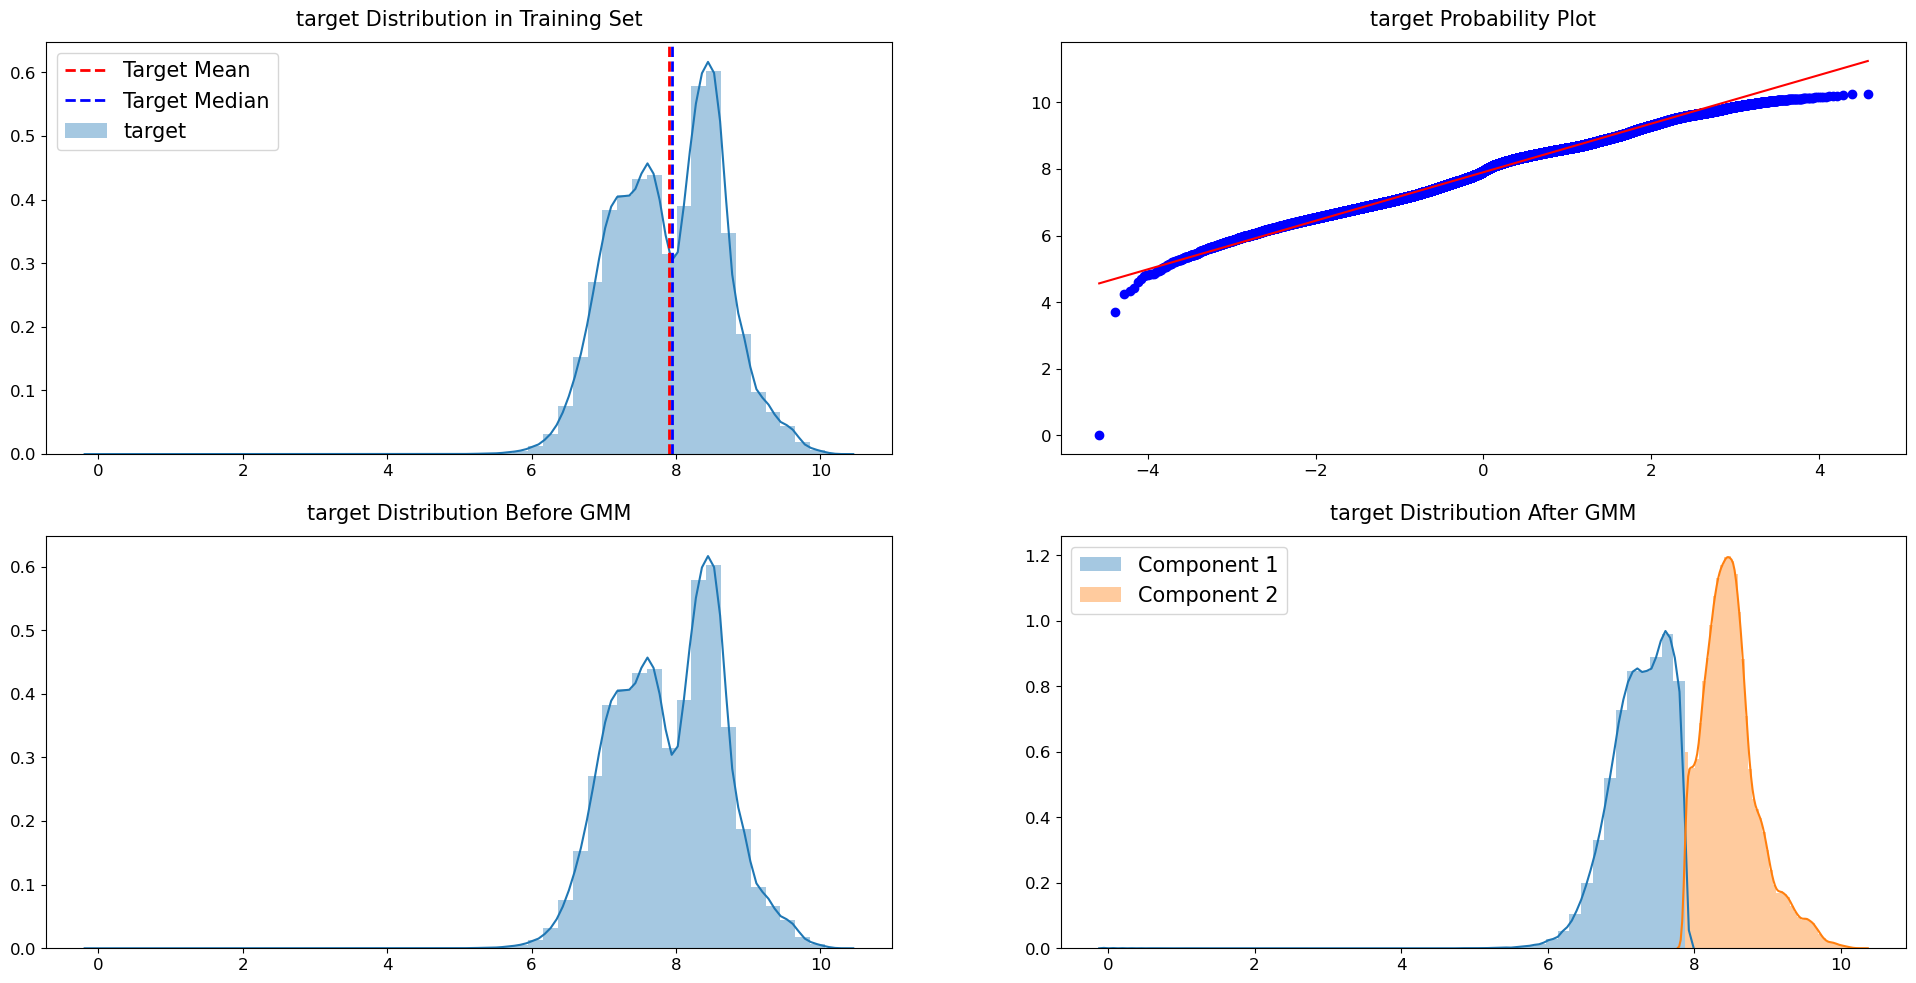

In [3]:
def plot_target(target):
    
    print(f'Target feature {target} Statistical Analysis\n{"-" * 42}')
        
    print(f'Mean: {df_train[target].mean():.4}  -  Median: {df_train[target].median():.4}  -  Std: {df_train[target].std():.4}')
    print(f'Min: {df_train[target].min():.4}  -  25%: {df_train[target].quantile(0.25):.4}  -  50%: {df_train[target].quantile(0.5):.4}  -  75%: {df_train[target].quantile(0.75):.4}  -  Max: {df_train[target].max():.4}')
    print(f'Skew: {df_train[target].skew():.4}  -  Kurtosis: {df_train[target].kurtosis():.4}')
    missing_values_count = df_train[df_train[target].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4}%)')

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12), dpi=100)

    sns.distplot(df_train[target], label=target, ax=axes[0][0])
    axes[0][0].axvline(df_train[target].mean(), label='Target Mean', color='r', linewidth=2, linestyle='--')
    axes[0][0].axvline(df_train[target].median(), label='Target Median', color='b', linewidth=2, linestyle='--')
    probplot(df_train[target], plot=axes[0][1])
    
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(df_train[target].values.reshape(-1, 1))
    df_train[f'{target}_class'] = gmm.predict(df_train[target].values.reshape(-1, 1))
    
    sns.distplot(df_train[target], label=target, ax=axes[1][0])
    sns.distplot(df_train[df_train[f'{target}_class'] == 0][target], label='Component 1', ax=axes[1][1])
    sns.distplot(df_train[df_train[f'{target}_class'] == 1][target], label='Component 2', ax=axes[1][1])
    
    axes[0][0].legend(prop={'size': 15})
    axes[1][1].legend(prop={'size': 15})
    
    for i in range(2):
        for j in range(2):
            axes[i][j].tick_params(axis='x', labelsize=12)
            axes[i][j].tick_params(axis='y', labelsize=12)
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
    axes[0][0].set_title(f'{target} Distribution in Training Set', fontsize=15, pad=12)
    axes[0][1].set_title(f'{target} Probability Plot', fontsize=15, pad=12)
    axes[1][0].set_title(f'{target} Distribution Before GMM', fontsize=15, pad=12)
    axes[1][1].set_title(f'{target} Distribution After GMM', fontsize=15, pad=12)
    plt.show()
    

plot_target(target)

## 2. Features

There are 14 continuous features that are named from `cont1` to `cont14`. All of their distributions are different from each other, but they have one thing in common. All of them have multimodal distributions which means they have multiple peaks. Number of peaks changes from feature to feature. None of the features have any missing values and their distributions are very similar in training and test sets.

Continuous feature cont1 Statistical Analysis
------------------------------------------
Training Mean: 0.5069  - Training Median: 0.484 - Training Std: 0.204
Test Mean: 0.5072  - Test Median: 0.4843 - Test Std: 0.2042
Training Min: -0.08226  - Training Max: 1.016
Test Min: -0.06164  - Training Max: 1.018
Training Skew: 0.5296  - Training Kurtosis: -0.2527
Test Skew: 0.5193  - Test Kurtosis: -0.2557
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


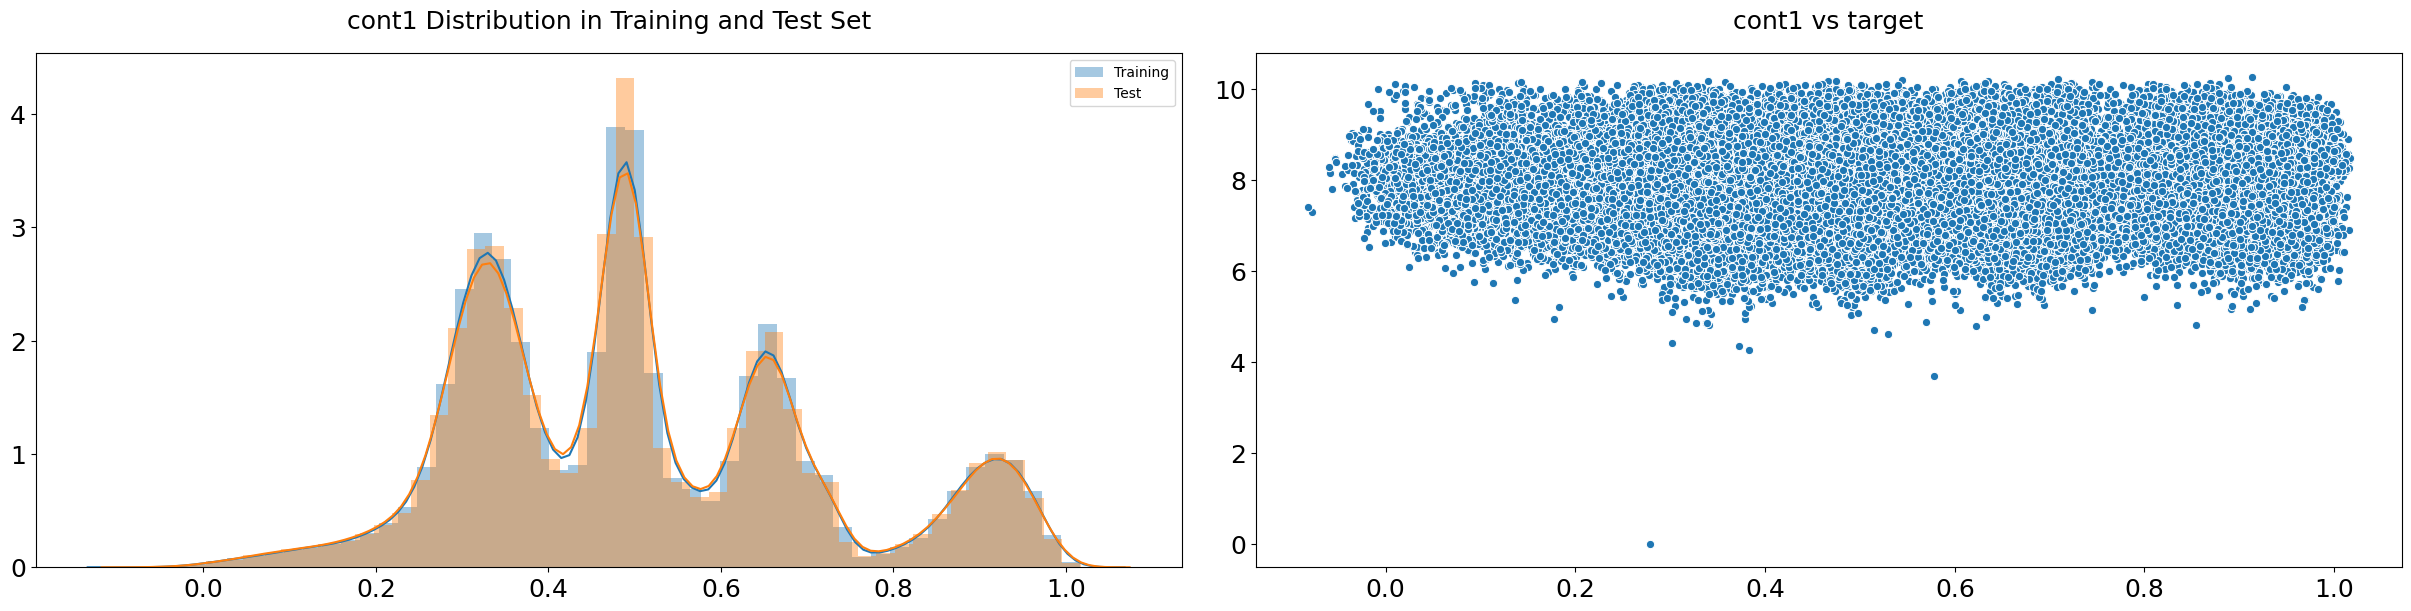

Continuous feature cont2 Statistical Analysis
------------------------------------------
Training Mean: 0.4979  - Training Median: 0.5532 - Training Std: 0.2282
Test Mean: 0.4981  - Test Median: 0.5531 - Test Std: 0.2279
Training Min: -0.0314  - Training Max: 0.8597
Test Min: -0.03055  - Training Max: 0.8538
Training Skew: -0.2481  - Training Kurtosis: -1.18
Test Skew: -0.2455  - Test Kurtosis: -1.18
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


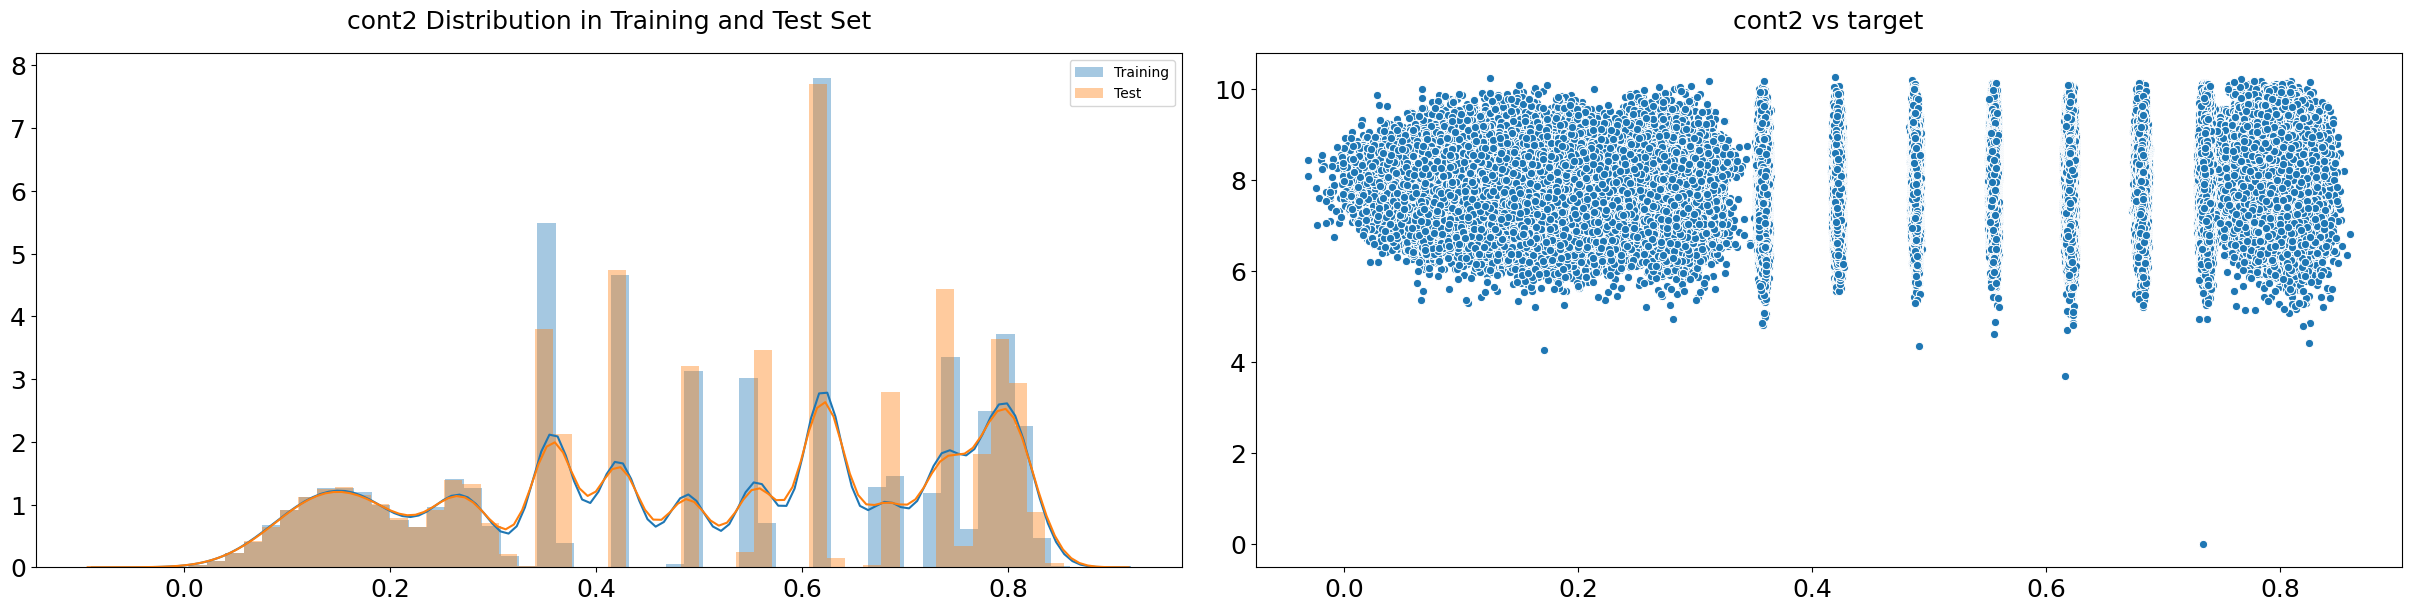

Continuous feature cont3 Statistical Analysis
------------------------------------------
Training Mean: 0.5216  - Training Median: 0.5515 - Training Std: 0.2008
Test Mean: 0.5214  - Test Median: 0.5514 - Test Std: 0.2007
Training Min: 0.02097  - Training Max: 1.007
Test Min: 0.04087  - Training Max: 1.002
Training Skew: 0.009037  - Training Kurtosis: -0.6715
Test Skew: 0.005117  - Test Kurtosis: -0.673
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


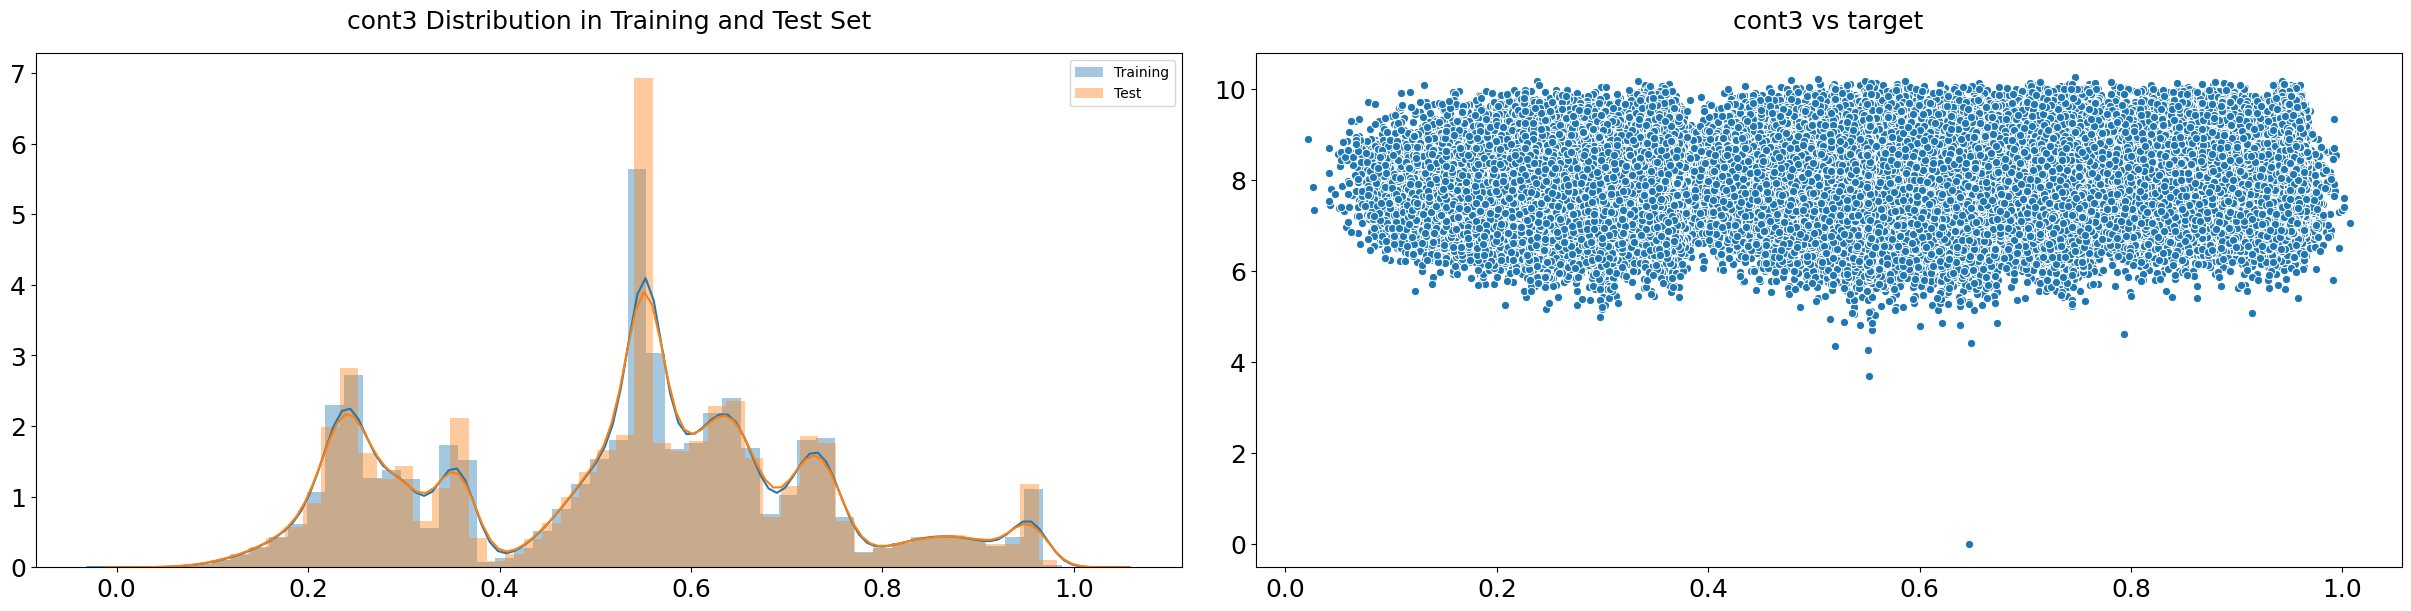

Continuous feature cont4 Statistical Analysis
------------------------------------------
Training Mean: 0.5157  - Training Median: 0.4829 - Training Std: 0.233
Test Mean: 0.5148  - Test Median: 0.482 - Test Std: 0.233
Training Min: 0.1528  - Training Max: 1.01
Test Min: 0.1533  - Training Max: 0.9974
Training Skew: 0.2504  - Training Kurtosis: -1.335
Test Skew: 0.2545  - Test Kurtosis: -1.333
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


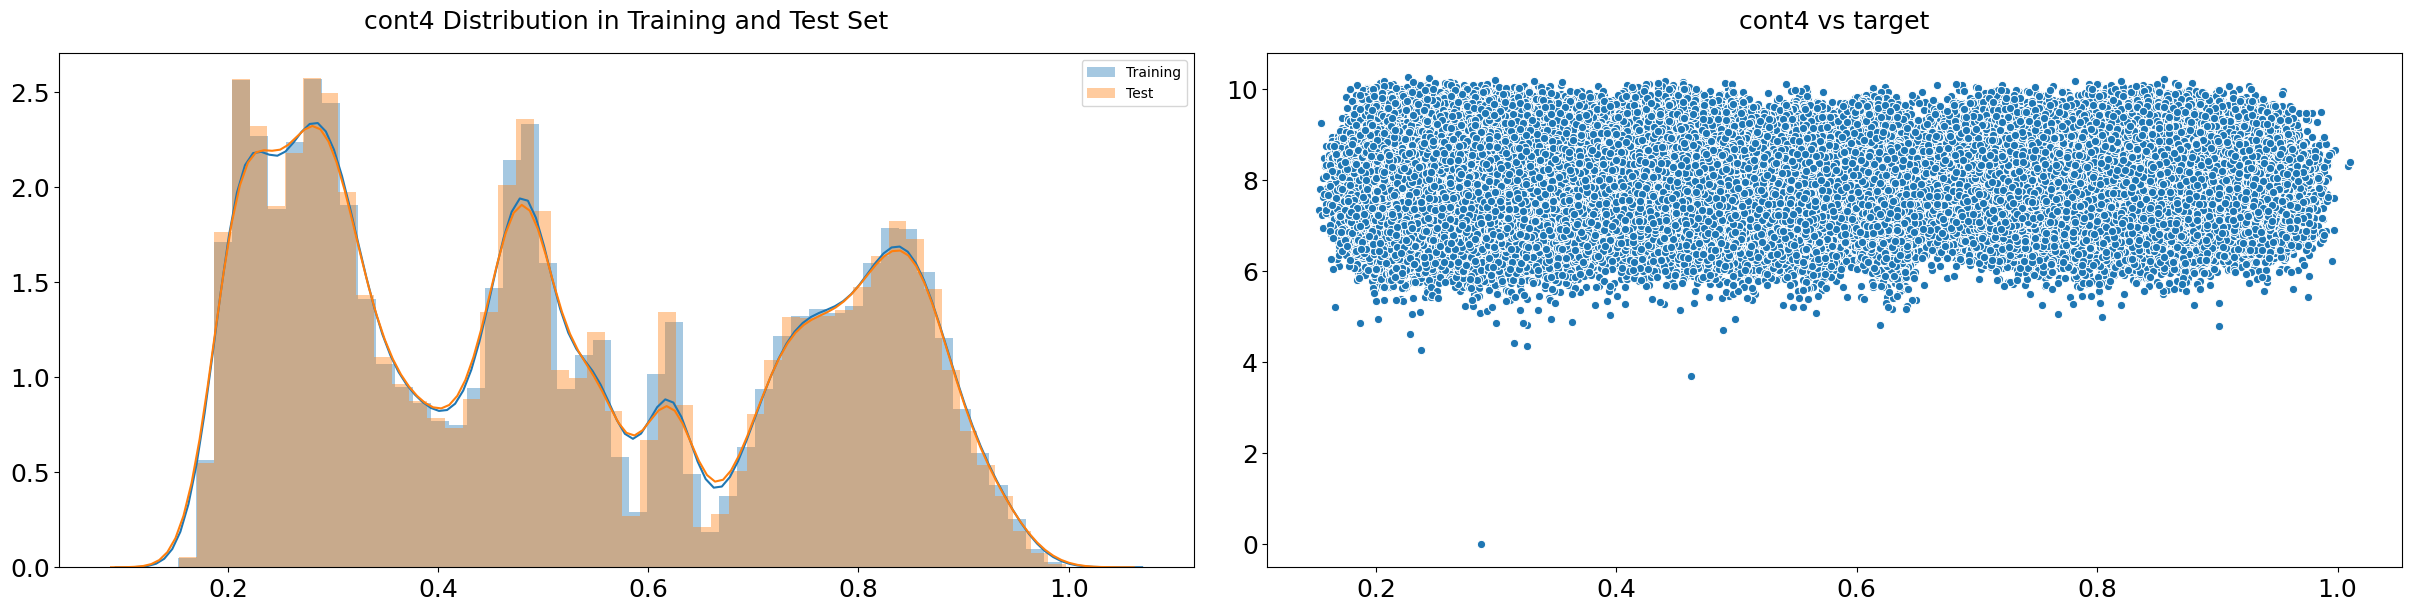

Continuous feature cont5 Statistical Analysis
------------------------------------------
Training Mean: 0.502  - Training Median: 0.4517 - Training Std: 0.2207
Test Mean: 0.5023  - Test Median: 0.452 - Test Std: 0.2208
Training Min: 0.2764  - Training Max: 1.034
Test Min: 0.2767  - Training Max: 1.034
Training Skew: 0.6103  - Training Kurtosis: -0.8878
Test Skew: 0.6079  - Test Kurtosis: -0.8919
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


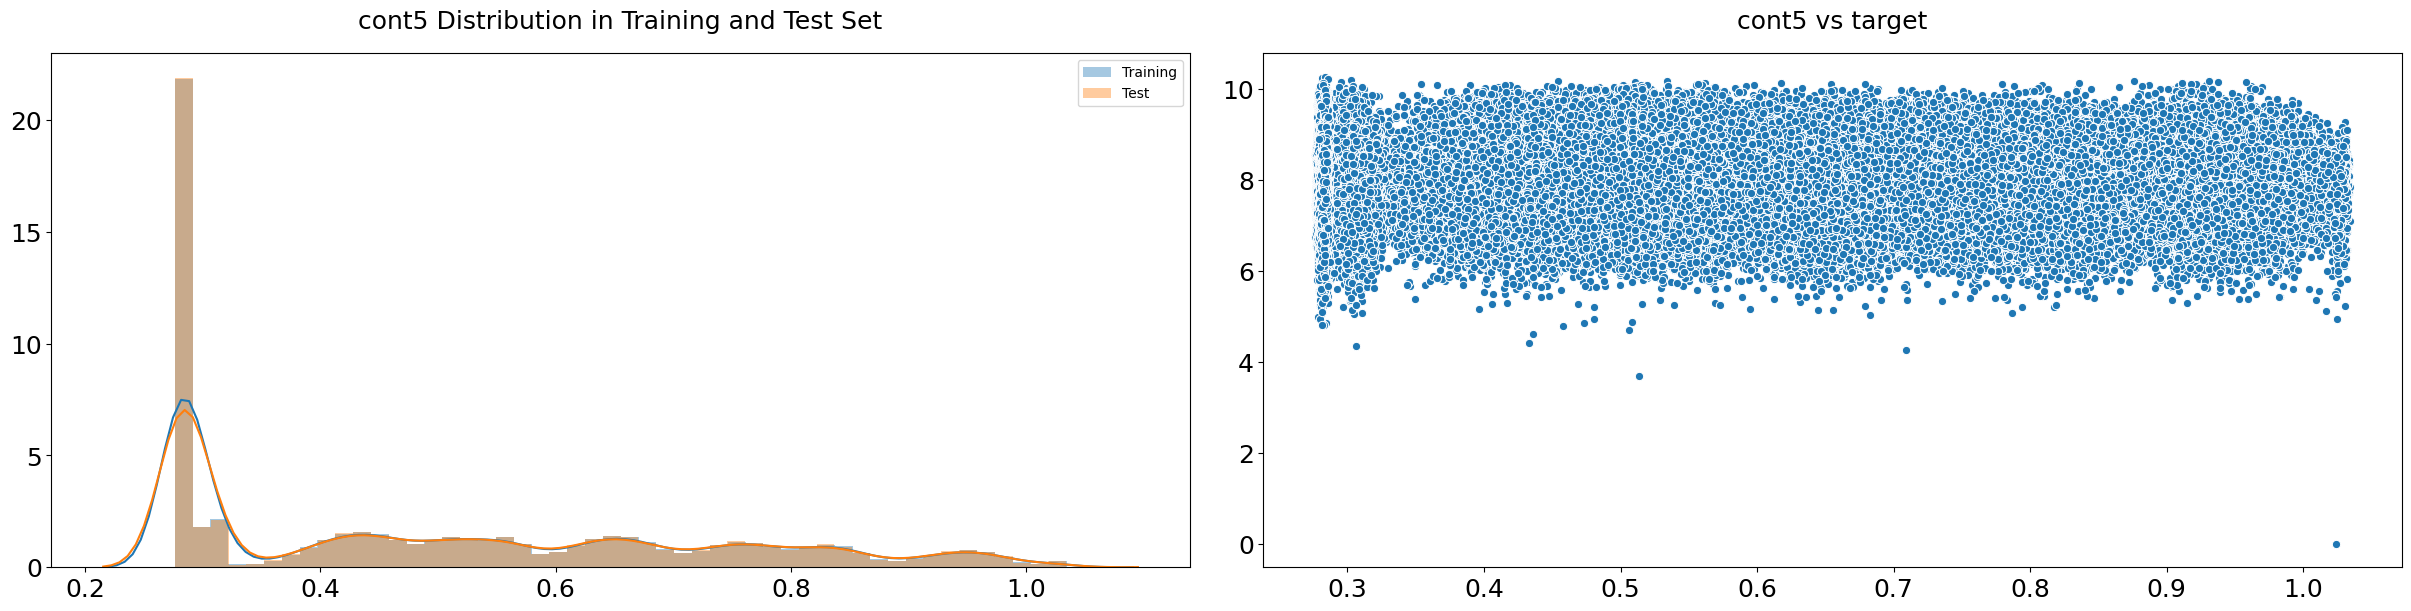

Continuous feature cont6 Statistical Analysis
------------------------------------------
Training Mean: 0.5265  - Training Median: 0.471 - Training Std: 0.2179
Test Mean: 0.527  - Test Median: 0.471 - Test Std: 0.2181
Training Min: 0.06617  - Training Max: 1.044
Test Min: 0.0751  - Training Max: 1.047
Training Skew: 0.538  - Training Kurtosis: -0.7997
Test Skew: 0.54  - Test Kurtosis: -0.8011
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


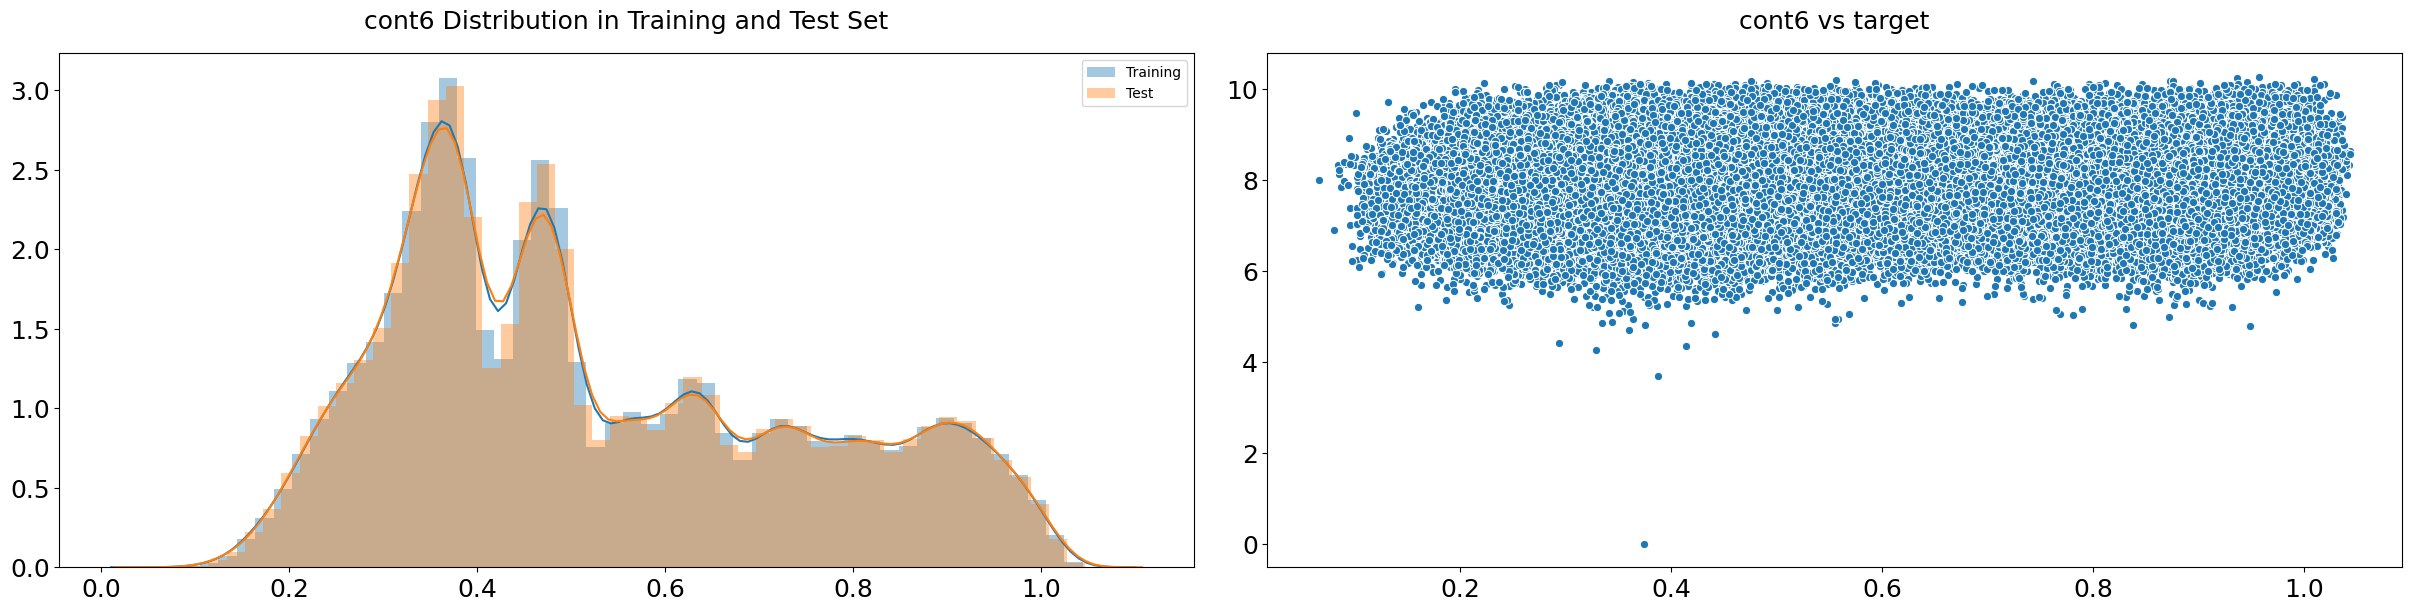

Continuous feature cont7 Statistical Analysis
------------------------------------------
Training Mean: 0.4879  - Training Median: 0.4668 - Training Std: 0.1811
Test Mean: 0.4877  - Test Median: 0.4664 - Test Std: 0.1808
Training Min: -0.09767  - Training Max: 1.066
Test Min: -0.02476  - Training Max: 1.054
Training Skew: 0.7034  - Training Kurtosis: -0.004491
Test Skew: 0.7022  - Test Kurtosis: -0.002599
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


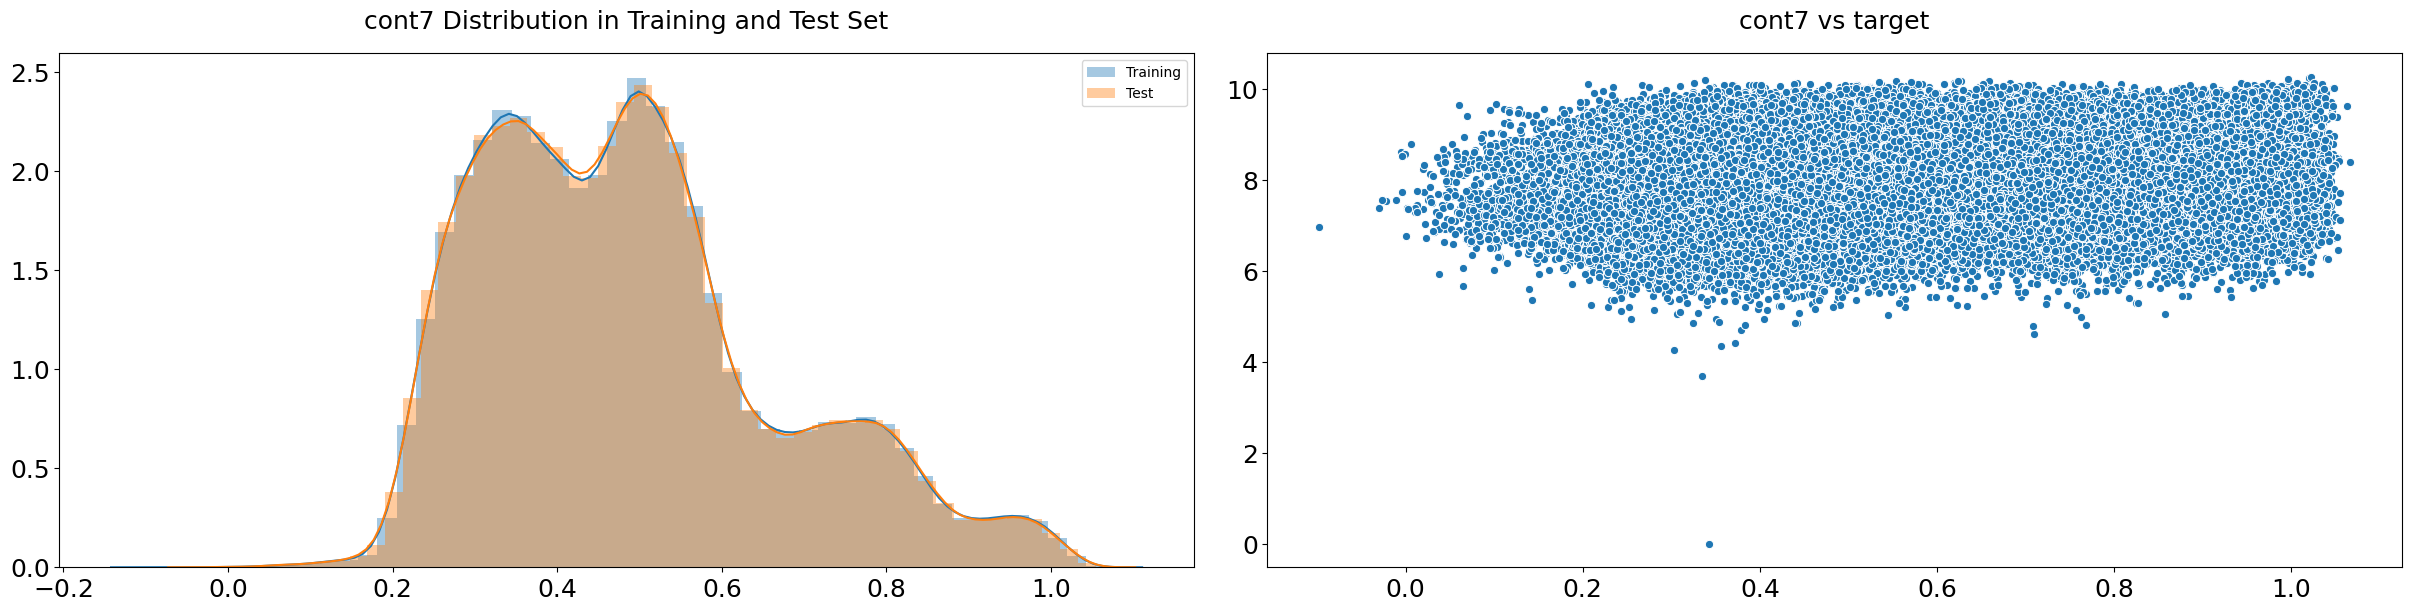

Continuous feature cont8 Statistical Analysis
------------------------------------------
Training Mean: 0.5252  - Training Median: 0.4835 - Training Std: 0.2162
Test Mean: 0.5253  - Test Median: 0.4838 - Test Std: 0.2161
Training Min: 0.2173  - Training Max: 1.024
Test Min: 0.2196  - Training Max: 1.026
Training Skew: 0.5697  - Training Kurtosis: -0.8781
Test Skew: 0.5688  - Test Kurtosis: -0.8797
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


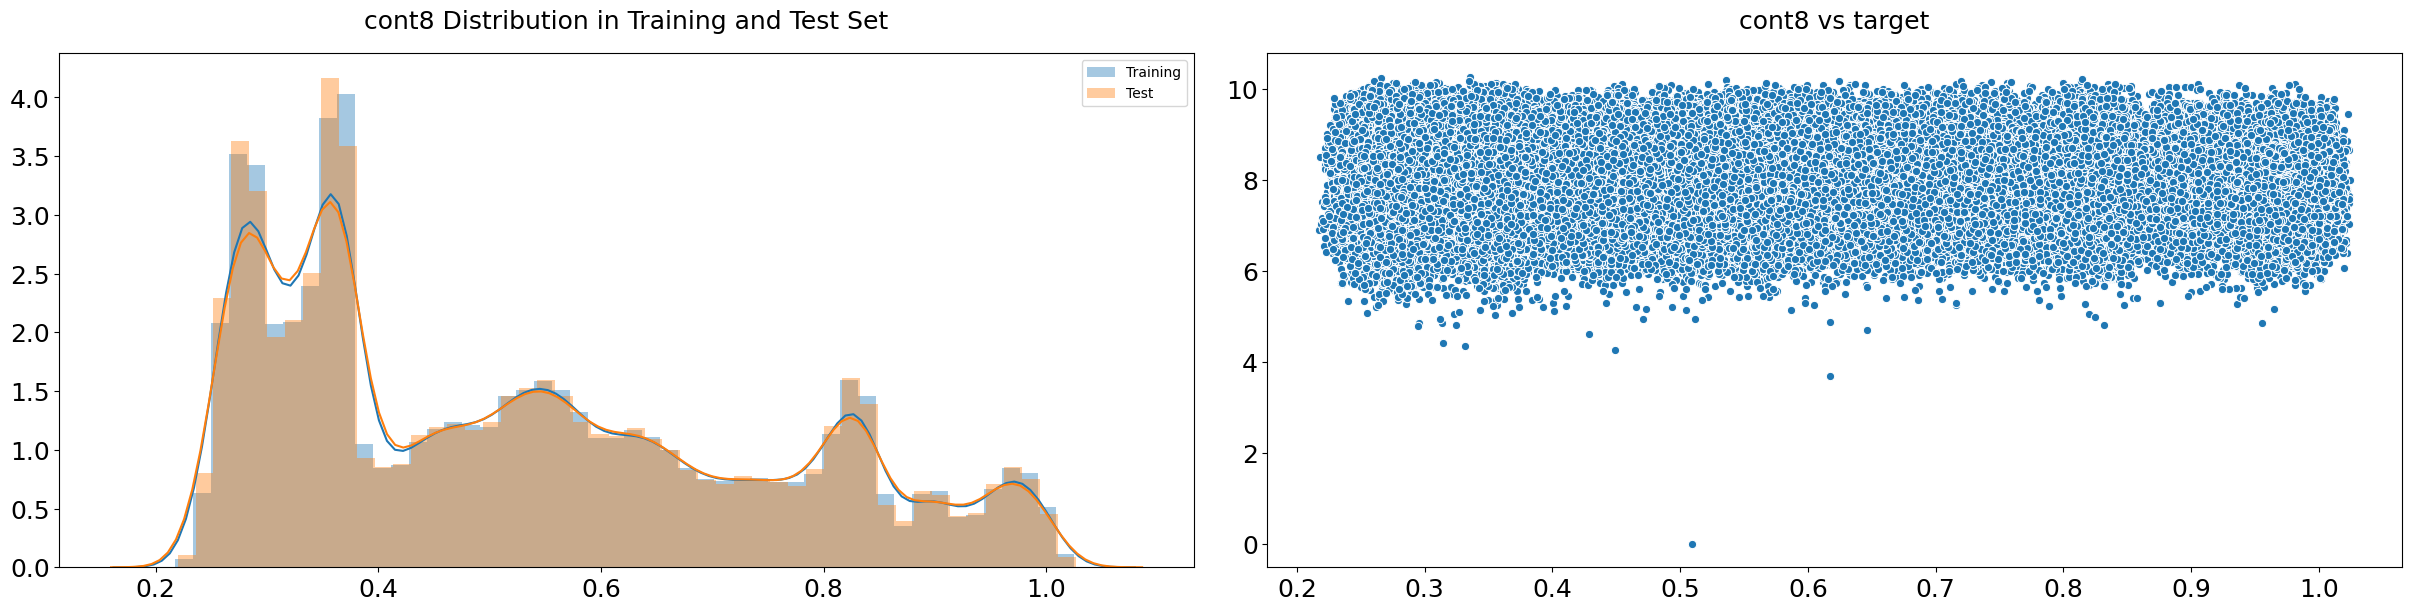

Continuous feature cont9 Statistical Analysis
------------------------------------------
Training Mean: 0.4599  - Training Median: 0.4168 - Training Std: 0.1967
Test Mean: 0.4603  - Test Median: 0.4169 - Test Std: 0.1972
Training Min: -0.2406  - Training Max: 1.004
Test Min: -0.2313  - Training Max: 1.001
Training Skew: 0.7962  - Training Kurtosis: 0.1957
Test Skew: 0.8004  - Test Kurtosis: 0.184
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


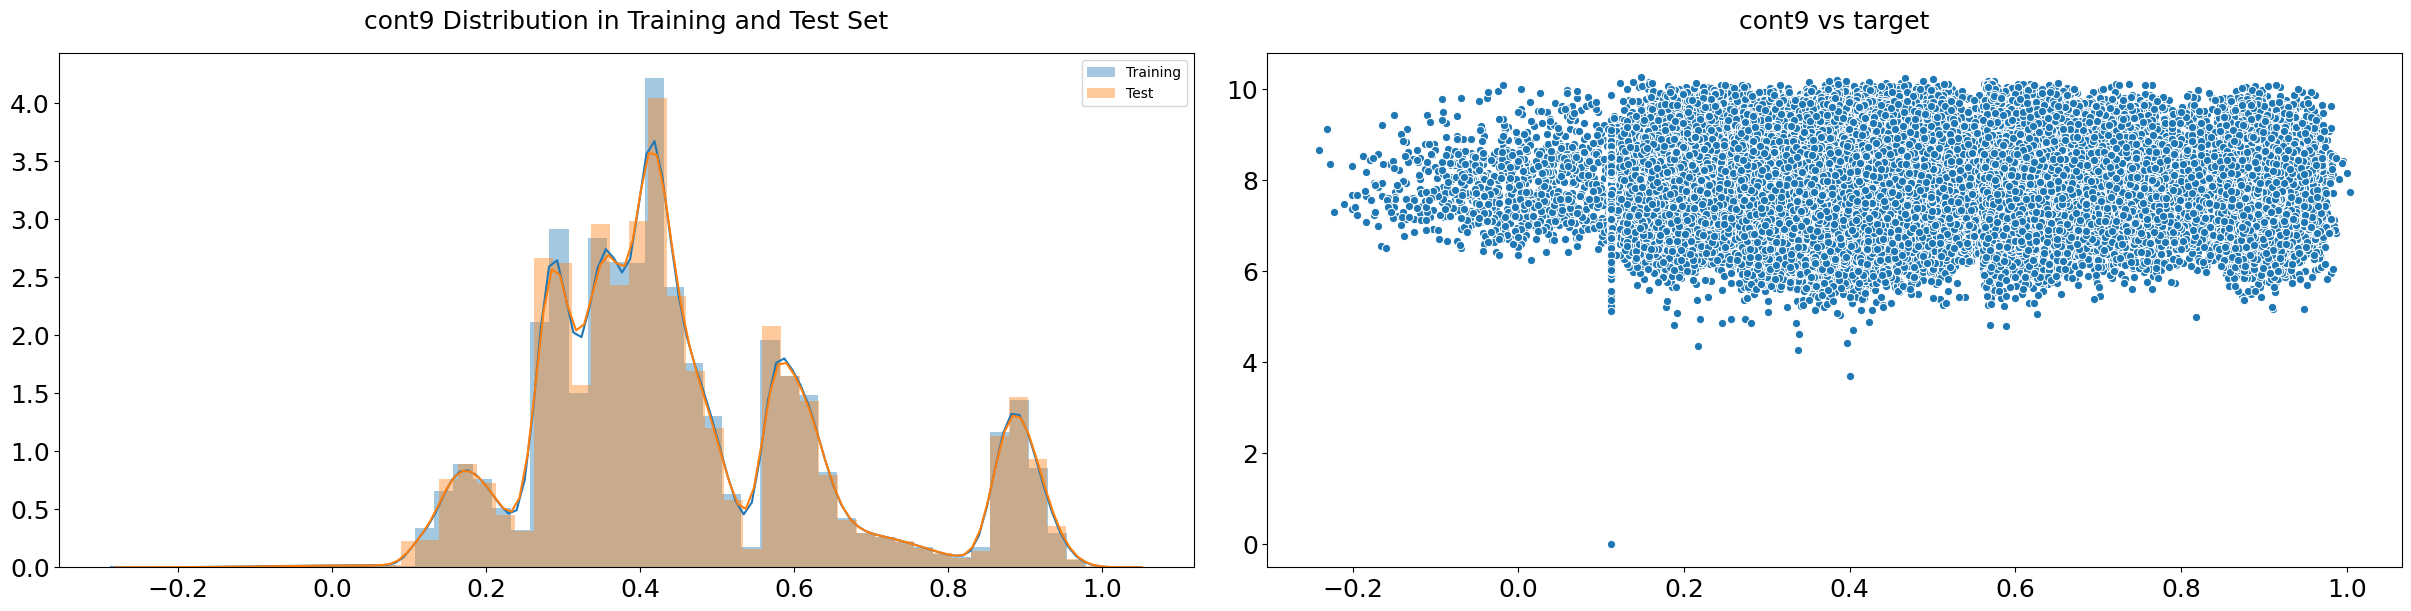

Continuous feature cont10 Statistical Analysis
------------------------------------------
Training Mean: 0.5205  - Training Median: 0.4589 - Training Std: 0.2019
Test Mean: 0.5205  - Test Median: 0.4586 - Test Std: 0.2016
Training Min: -0.08505  - Training Max: 1.2
Test Min: -0.1098  - Training Max: 1.141
Training Skew: 0.3626  - Training Kurtosis: -1.052
Test Skew: 0.3641  - Test Kurtosis: -1.051
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


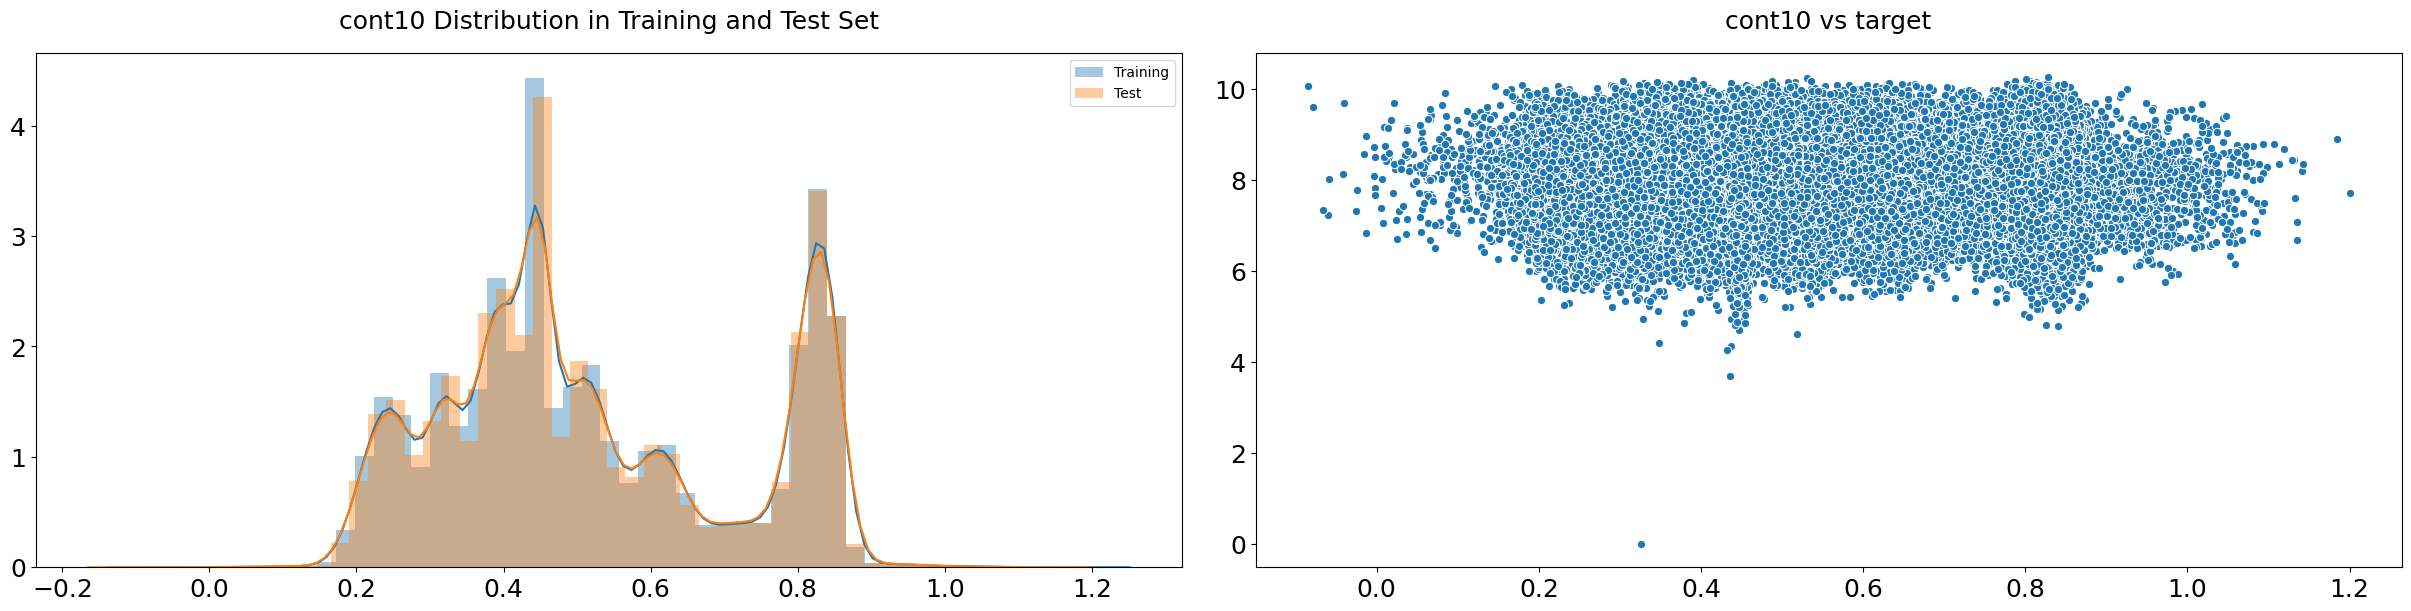

Continuous feature cont11 Statistical Analysis
------------------------------------------
Training Mean: 0.4839  - Training Median: 0.4419 - Training Std: 0.2201
Test Mean: 0.4842  - Test Median: 0.442 - Test Std: 0.22
Training Min: 0.08328  - Training Max: 1.023
Test Min: 0.07886  - Training Max: 1.023
Training Skew: 0.4194  - Training Kurtosis: -0.9534
Test Skew: 0.4233  - Test Kurtosis: -0.9456
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


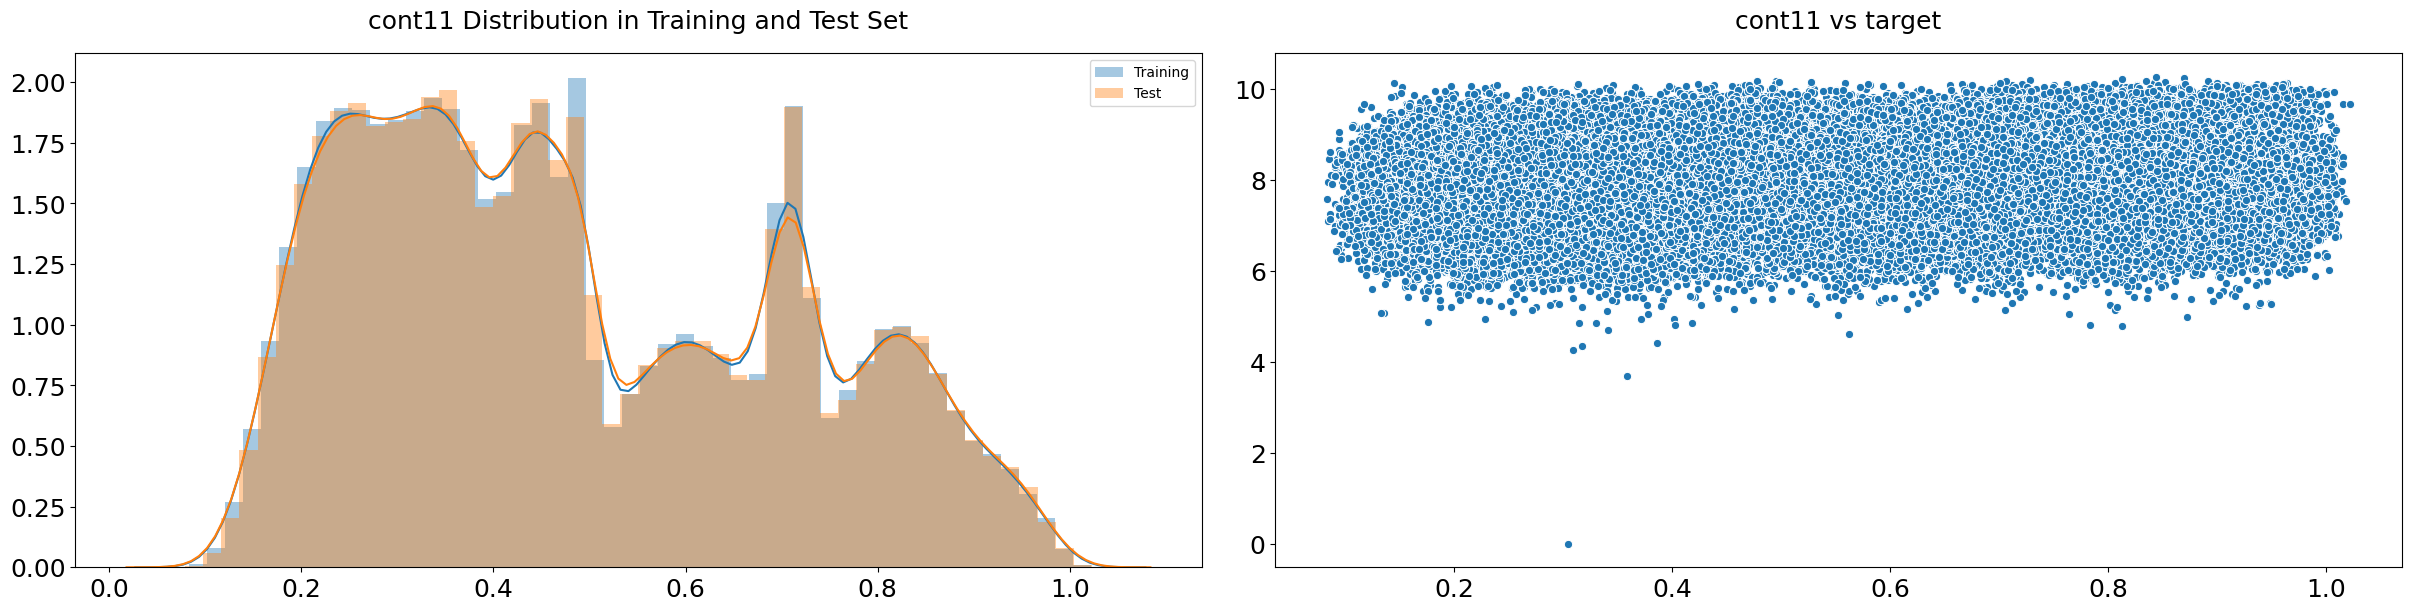

Continuous feature cont12 Statistical Analysis
------------------------------------------
Training Mean: 0.5069  - Training Median: 0.4866 - Training Std: 0.2189
Test Mean: 0.5068  - Test Median: 0.4855 - Test Std: 0.2186
Training Min: 0.08863  - Training Max: 1.049
Test Min: 0.0945  - Training Max: 1.049
Training Skew: 0.2832  - Training Kurtosis: -1.13
Test Skew: 0.2849  - Test Kurtosis: -1.13
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


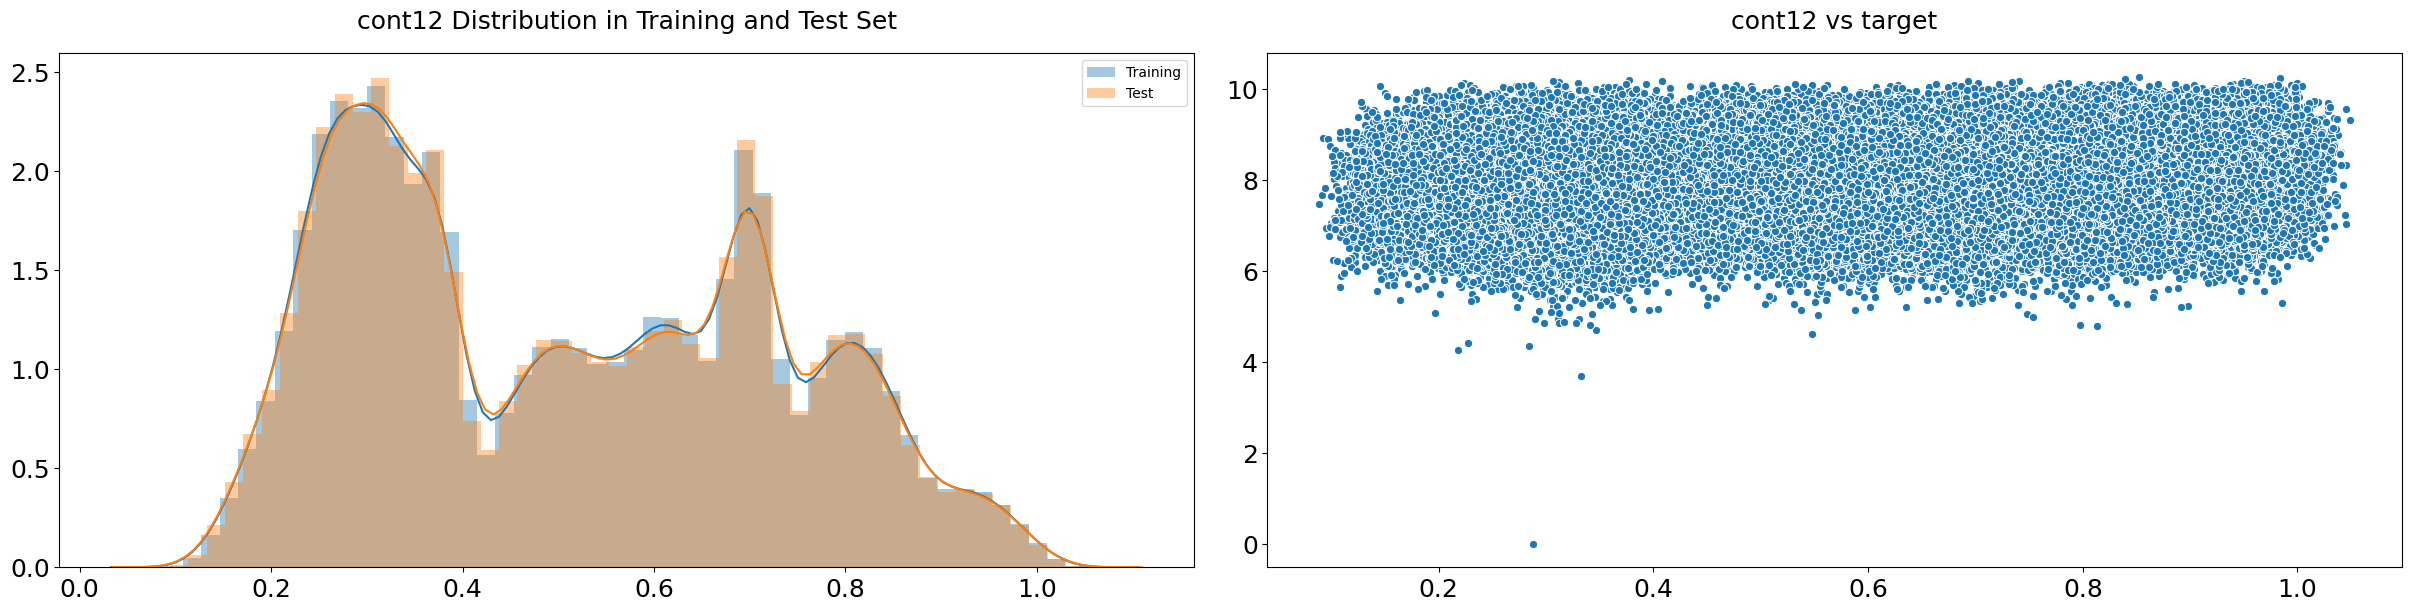

Continuous feature cont13 Statistical Analysis
------------------------------------------
Training Mean: 0.5534  - Training Median: 0.4877 - Training Std: 0.2297
Test Mean: 0.5544  - Test Median: 0.4915 - Test Std: 0.2297
Training Min: 0.02995  - Training Max: 0.9778
Test Min: 0.01537  - Training Max: 0.9772
Training Skew: 0.3203  - Training Kurtosis: -1.387
Test Skew: 0.3159  - Test Kurtosis: -1.386
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


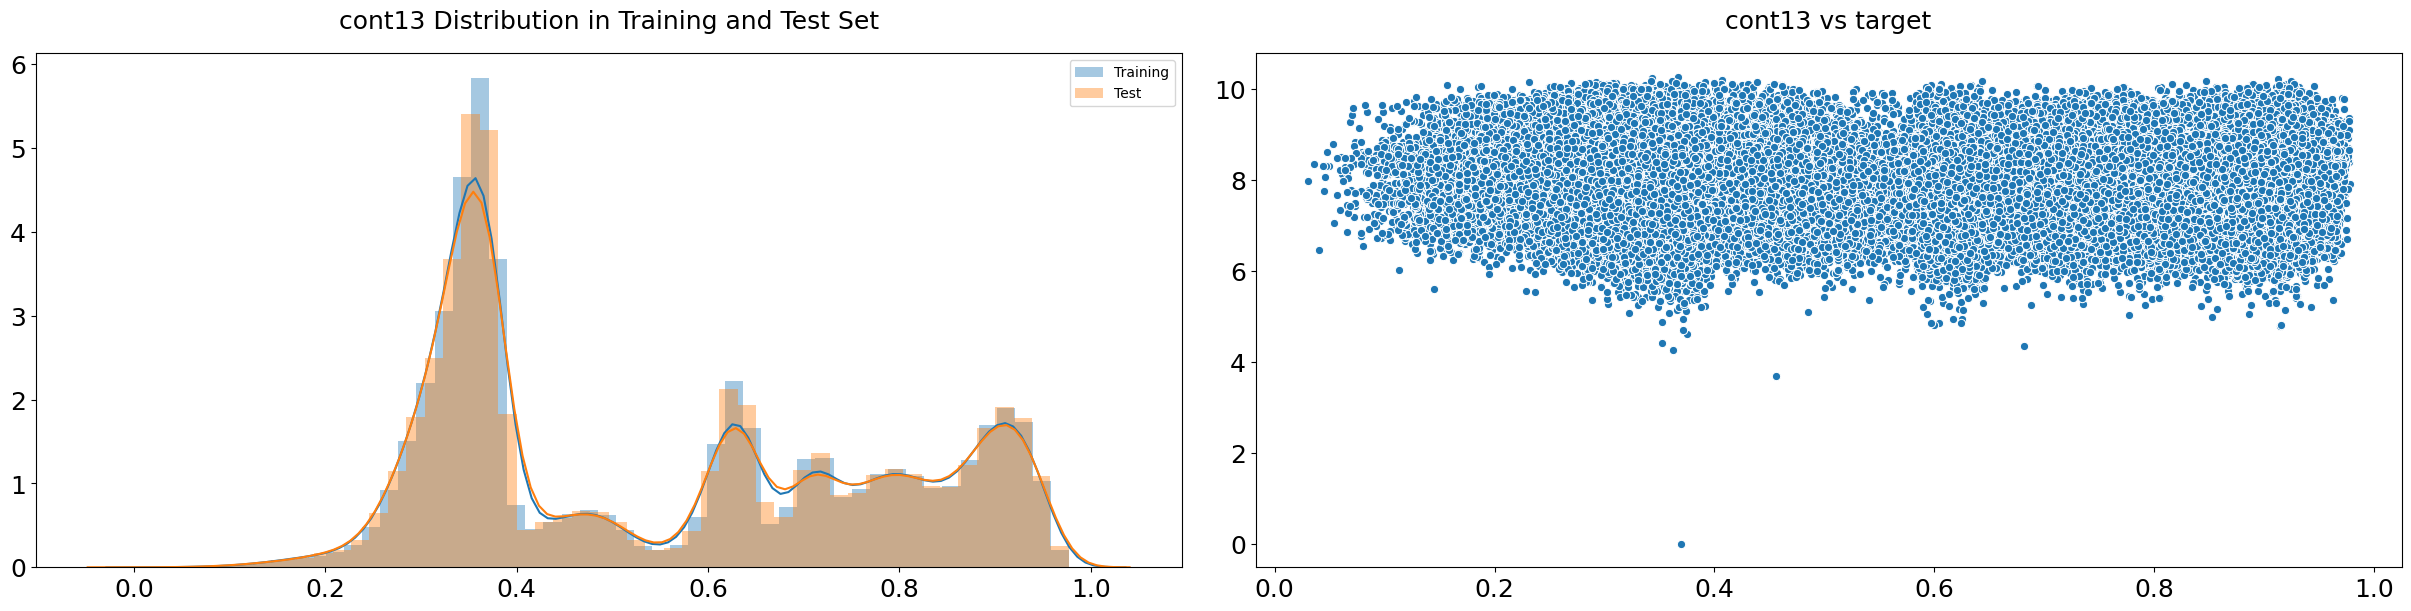

Continuous feature cont14 Statistical Analysis
------------------------------------------
Training Mean: 0.5037  - Training Median: 0.4318 - Training Std: 0.2082
Test Mean: 0.5032  - Test Median: 0.4311 - Test Std: 0.2083
Training Min: 0.1664  - Training Max: 0.8685
Test Min: 0.1645  - Training Max: 0.8687
Training Skew: 0.2525  - Training Kurtosis: -1.423
Test Skew: 0.2543  - Test Kurtosis: -1.422
Training Missing Values: 0/300000 (0.0%)
Test Missing Values: 0/200000 (0.0%)


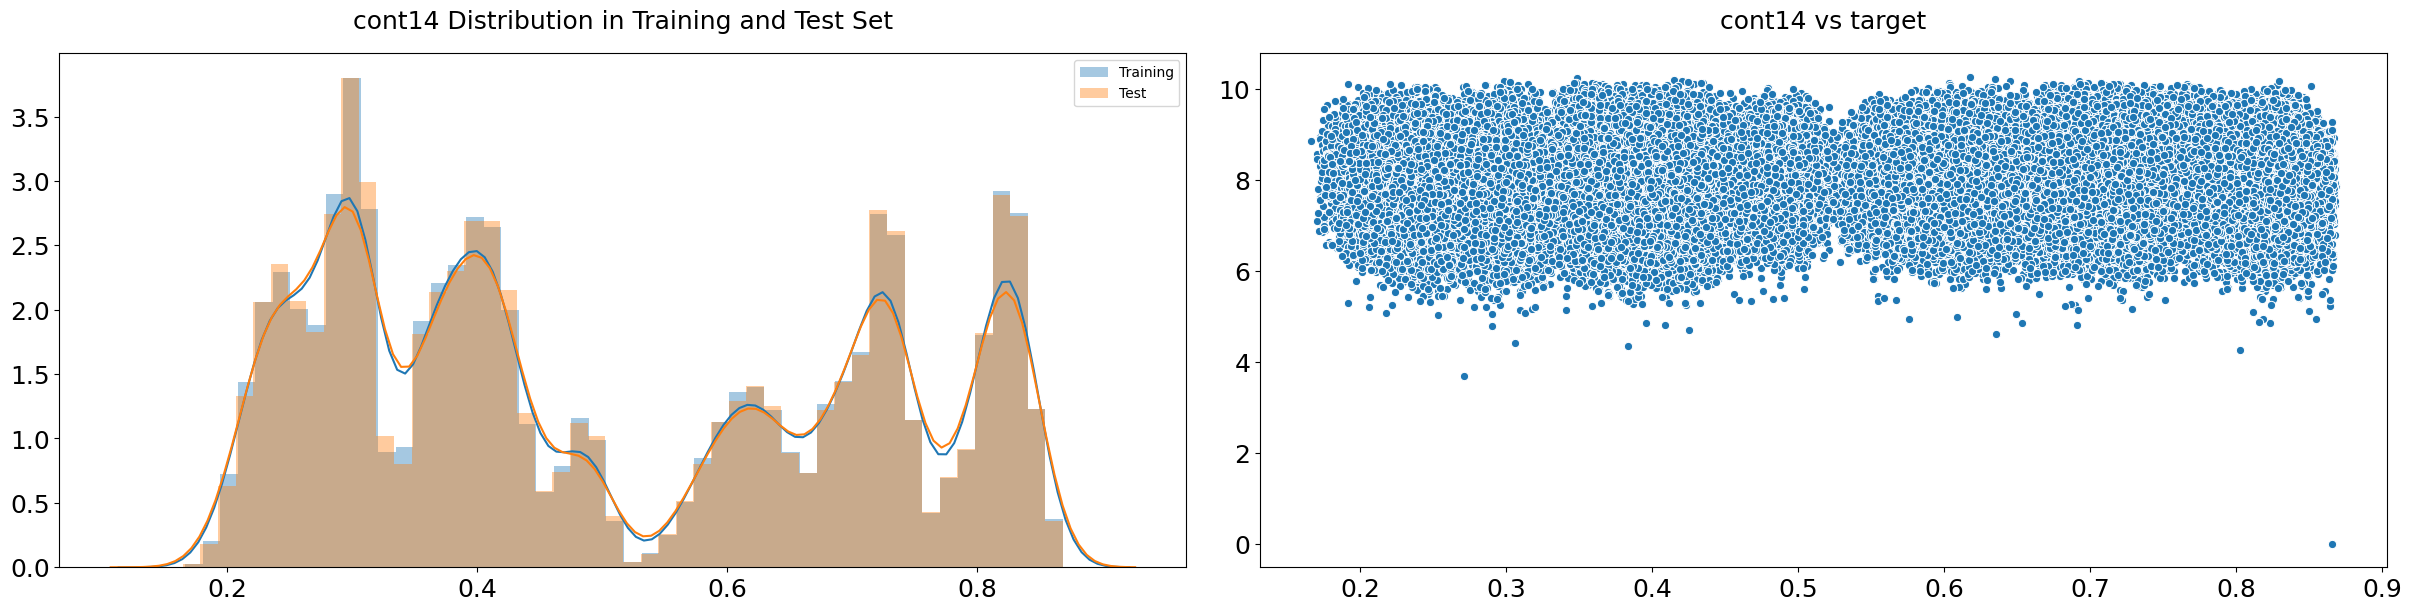

In [4]:
def plot_continuous(continuous_feature):
            
    print(f'Continuous feature {continuous_feature} Statistical Analysis\n{"-" * 42}')

    print(f'Training Mean: {float(df_train[continuous_feature].mean()):.4}  - Training Median: {float(df_train[continuous_feature].median()):.4} - Training Std: {float(df_train[continuous_feature].std()):.4}')
    print(f'Test Mean: {float(df_test[continuous_feature].mean()):.4}  - Test Median: {float(df_test[continuous_feature].median()):.4} - Test Std: {float(df_test[continuous_feature].std()):.4}')
    print(f'Training Min: {float(df_train[continuous_feature].min()):.4}  - Training Max: {float(df_train[continuous_feature].max()):.4}')
    print(f'Test Min: {float(df_test[continuous_feature].min()):.4}  - Training Max: {float(df_test[continuous_feature].max()):.4}')
    print(f'Training Skew: {float(df_train[continuous_feature].skew()):.4}  - Training Kurtosis: {float(df_train[continuous_feature].kurtosis()):.4}')
    print(f'Test Skew: {float(df_test[continuous_feature].skew()):.4}  - Test Kurtosis: {float(df_test[continuous_feature].kurtosis()):.4}')
    training_missing_values_count = df_train[df_train[continuous_feature].isnull()].shape[0]
    test_missing_values_count = df_test[df_test[continuous_feature].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    test_samples_count = df_test.shape[0]
    print(f'Training Missing Values: {training_missing_values_count}/{training_samples_count} ({training_missing_values_count * 100 / training_samples_count:.4}%)')
    print(f'Test Missing Values: {test_missing_values_count}/{test_samples_count} ({test_missing_values_count * 100 / test_samples_count:.4}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100, constrained_layout=True)
    title_size = 18
    label_size = 18

    # Continuous Feature Training and Test Set Distribution
    sns.distplot(df_train[continuous_feature], label='Training', ax=axes[0])
    sns.distplot(df_test[continuous_feature], label='Test', ax=axes[0])
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', labelsize=label_size)
    axes[0].tick_params(axis='y', labelsize=label_size)
    axes[0].legend()
    axes[0].set_title(f'{continuous_feature} Distribution in Training and Test Set', size=title_size, pad=title_size)
    
    # Continuous Feature vs target
    sns.scatterplot(df_train[continuous_feature], df_train[target], ax=axes[1])
    axes[1].set_title(f'{continuous_feature} vs {target}', size=title_size, pad=title_size)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', labelsize=label_size)
    axes[1].tick_params(axis='y', labelsize=label_size)
    
    plt.show()
    
    
for continuous_feature in sorted(continuous_features, key=lambda x: int(x.split('cont')[-1])):
    plot_continuous(continuous_feature)

## 3. Preprocessing

`Preprocessor` class incorporates the preprocessing steps such as cross-validation folds creation, outlier removal, standardization and feature engineering.

* Two outliers data points in `target` that are less than 4, are dropped
* Created 5 random split folds for cross-validation
* Continuous features are standardized for linear and neural network models, but it is not necessary for tree-based models
* Peak features are created for capturing vertical patterns in feature x target interactions but they didn't improve any of the model performances
* argmax and argmin features are created for continuous features but they didn't improve any of the model performances
* Continuous features are discretized with distribution components extracted by a gaussian mixture model 

In [5]:
class Preprocessor:
    
    def __init__(self, train, test, n_splits, shuffle, random_state, scaler, discretize_features, create_features):
        
        self.train = train.copy(deep=True)        
        self.test = test.copy(deep=True)   
        
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
        self.scaler = scaler() if scaler else None
        self.discretize_features = discretize_features
        self.create_features = create_features
        
    def drop_outliers(self):
        
        outlier_idx = self.train[self.train[target] < 4].index
        self.train.drop(outlier_idx, inplace=True)
        self.train.reset_index(drop=True, inplace=True)
        
        print(f'Dropped {len(outlier_idx)} outliers')
        del outlier_idx
        
    def create_folds(self):
                
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        for fold, (_, val_idx) in enumerate(kf.split(self.train), 1):
            self.train.loc[val_idx, 'fold'] = fold

        self.train['fold'] = self.train['fold'].astype(np.uint8)
                
    def scale(self):
        
        df_all = pd.concat([self.train[continuous_features], self.test[continuous_features]], ignore_index=True, axis=0)
        self.scaler.fit(df_all[continuous_features])
        self.train.loc[:, continuous_features] = self.scaler.transform(self.train.loc[:, continuous_features].values)
        self.test.loc[:, continuous_features] = self.scaler.transform(self.test.loc[:, continuous_features].values)
        
        print(f'Scaled {len(continuous_features)} features with {self.scaler.__class__.__name__}')
        del df_all
        
    def create_peak_features(self):
        
        for df in [self.train, self.test]:
            df['cont2_peak'] = ((df_train['cont2'].round(2) == 0.36) | (df_train['cont2'].round(2) == 0.42) | (df_train['cont2'].round(2) == 0.49) |\
                                (df_train['cont2'].round(2) == 0.55) | (df_train['cont2'].round(2) == 0.56) | (df_train['cont2'].round(2) == 0.62) |\
                                (df_train['cont2'].round(2) == 0.68) | (df_train['cont2'].round(2) == 0.74)).astype(np.uint8)
            
            df['cont5_peak'] = (df_train['cont5'].round(2) == 0.28).astype(np.uint8)
            
        peak_features = ['cont2_peak', 'cont5_peak']
        print(f'Created {len(peak_features)} peak features')
            
    def create_idx_features(self):
        
        for df in [self.train, self.test]:
            df['cont_argmin'] = np.argmin(df[continuous_features].values, axis=1)
            df['cont_argmax'] = np.argmax(df[continuous_features].values, axis=1)
            
        idx_features = ['cont_argmin', 'cont_argmax']
        print(f'Created {len(idx_features)} idx features with argmin and argmax')
            
    def create_gmm_features(self):
        
        n_component_mapping = {
            1: 4,
            2: 10,
            3: 6,
            4: 4,
            5: 3,
            6: 2,
            7: 3,
            8: 4,
            9: 4,
            10: 8,
            11: 5,
            12: 4,
            13: 6,
            14: 6
        }
        
        for i in range(1, 15):
            gmm = GaussianMixture(n_components=n_component_mapping[i], random_state=self.random_state)            
            gmm.fit(pd.concat([self.train[f'cont{i}'], self.test[f'cont{i}']], axis=0).values.reshape(-1, 1))
            
            self.train[f'cont{i}_class'] = gmm.predict(self.train[f'cont{i}'].values.reshape(-1, 1))
            self.test[f'cont{i}_class'] = gmm.predict(self.test[f'cont{i}'].values.reshape(-1, 1))
            
        gmm_features = [f'cont{i}_class' for i in range(1, 15)]
        print(f'Created {len(gmm_features)} gmm features with GaussianMixture')
                
    def transform(self):
        
        self.drop_outliers()
        self.create_folds()
        
        if self.create_features:
            self.create_peak_features()
            self.create_idx_features()
            
        if self.discretize_features:
            self.create_gmm_features()
                    
        if self.scaler:
            self.scale()
        
        return self.train.copy(deep=True), self.test.copy(deep=True)


This is the example usage of preprocessing pipeline. It returns processed training and test sets ready for model training, but those dataframes created in this cell are only used for storing model predictions. Models are trained with their custom datasets that designed specifically for them.

In [6]:
cross_validation_seed = 0
preprocessor = Preprocessor(train=df_train, test=df_test,
                            n_splits=5, shuffle=True, random_state=cross_validation_seed,
                            scaler=None,
                            create_features=False, discretize_features=False)
df_train_processed, df_test_processed = preprocessor.transform()

print(f'\nPreprocessed Training Set Shape = {df_train_processed.shape}')
print(f'Preprocessed Training Set Memory Usage = {df_train_processed.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Preprocessed Test Set Shape = {df_test_processed.shape}')
print(f'Preprocessed Test Set Memory Usage = {df_test_processed.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

Dropped 2 outliers

Preprocessed Training Set Shape = (299998, 18)
Preprocessed Training Set Memory Usage = 39.20 MB
Preprocessed Test Set Shape = (200000, 15)
Preprocessed Test Set Memory Usage = 22.89 MB



## 4. Tree-based Models

4 tree-based models are used in the ensemble and they are LightGBM, CatBoost, XGBoost, and Random Forest. All of them are trained with more than 3 seeds for diversity. Only raw continuous features are used in tree-based models without any transformation. Even though the training logs are not present in this version of the notebook, those are the parameters used for getting the scores displayed below each cell.

In [7]:
class TreeModels:
    
    def __init__(self, predictors, target, model, model_parameters, boosting_rounds, early_stopping_rounds, seeds):
        
        self.predictors = predictors
        self.target = target
               
        self.model = model
        self.model_parameters = model_parameters
        self.boosting_rounds = boosting_rounds
        self.early_stopping_rounds = early_stopping_rounds
        self.seeds = seeds
                
    def _train_and_predict_lgb(self, X_train, y_train, X_test):
        
        seed_avg_oof_predictions = np.zeros(X_train.shape[0])
        seed_avg_test_predictions = np.zeros(X_test.shape[0])        
        seed_avg_importance = pd.DataFrame(data=np.zeros(len(self.predictors)), index=self.predictors, columns=['Importance'])
        
        for seed in self.seeds:
            print(f'{"-" * 30}\nRunning LightGBM model with seed: {seed}\n{"-" * 30}\n')
            self.model_parameters['seed'] = seed
            self.model_parameters['feature_fraction_seed'] = seed
            self.model_parameters['bagging_seed'] = seed
            self.model_parameters['drop_seed'] = seed
            self.model_parameters['data_random_seed'] = seed
                
            for fold in sorted(X_train['fold'].unique()):

                trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index
                trn = lgb.Dataset(X_train.loc[trn_idx, self.predictors], label=y_train.loc[trn_idx])
                val = lgb.Dataset(X_train.loc[val_idx, self.predictors], label=y_train.loc[val_idx])

                model = lgb.train(params=self.model_parameters,
                                  train_set=trn,
                                  valid_sets=[trn, val],
                                  num_boost_round=self.boosting_rounds,
                                  early_stopping_rounds=self.early_stopping_rounds,
                                  verbose_eval=500)            

                val_predictions = model.predict(X_train.loc[val_idx, self.predictors])
                seed_avg_oof_predictions[val_idx] += (val_predictions / len(self.seeds))
                test_predictions = model.predict(X_test[self.predictors])
                seed_avg_test_predictions += (test_predictions / X_train['fold'].nunique() / len(self.seeds))
                seed_avg_importance['Importance'] += (model.feature_importance(importance_type='gain') / X_train['fold'].nunique() / len(self.seeds))

                fold_score = mean_squared_error(y_train.loc[val_idx], val_predictions, squared=False)
                print(f'\nLGB Fold {int(fold)} - X_trn: {X_train.loc[trn_idx, self.predictors].shape} X_val: {X_train.loc[val_idx, self.predictors].shape} - Score: {fold_score:.6} - Seed: {seed}\n')
            
        df_train_processed['LGBPredictions'] = seed_avg_oof_predictions
        df_test_processed['LGBPredictions'] = seed_avg_test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['LGBPredictions'], squared=False)
        print(f'{"-" * 30}\nLGB OOF RMSE: {oof_score:.6} ({len(self.seeds)} Seed Average)\n{"-" * 30}')
                
        self._plot_importance(seed_avg_importance)
        self._plot_predictions(df_train_processed[target], df_train_processed['LGBPredictions'], df_test_processed['LGBPredictions'])
        
    def _train_and_predict_cb(self, X_train, y_train, X_test):
        
        seed_avg_oof_predictions = np.zeros(X_train.shape[0])
        seed_avg_test_predictions = np.zeros(X_test.shape[0])        
        seed_avg_importance = pd.DataFrame(data=np.zeros(len(self.predictors)), index=self.predictors, columns=['Importance'])
            
        for seed in self.seeds:
            print(f'{"-" * 30}\nRunning CatBoost model with seed: {seed}\n{"-" * 30}\n')
            self.model_parameters['random_seed'] = seed
            
            for fold in sorted(X_train['fold'].unique()):

                trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index
                trn = cb.Pool(X_train.loc[trn_idx, self.predictors], label=y_train.loc[trn_idx])
                val = cb.Pool(X_train.loc[val_idx, self.predictors], label=y_train.loc[val_idx])

                model = cb.CatBoostRegressor(**self.model_parameters)
                model.fit(X=trn, eval_set=val)

                val_predictions = model.predict(val)
                seed_avg_oof_predictions[val_idx] += (val_predictions / len(self.seeds))
                test_predictions = model.predict(cb.Pool(X_test[self.predictors]))
                seed_avg_test_predictions += (test_predictions / X_train['fold'].nunique() / len(self.seeds))
                seed_avg_importance['Importance'] += (model.get_feature_importance() / X_train['fold'].nunique() / len(self.seeds))

                fold_score = mean_squared_error(df_train_processed.loc[val_idx, self.target], val_predictions, squared=False)
                print(f'\nCB Fold {int(fold)} - X_trn: {X_train.loc[trn_idx, self.predictors].shape} X_val: {X_train.loc[val_idx, self.predictors].shape} - Score: {fold_score:.6} - Seed: {seed}\n')
            
        df_train_processed['CBPredictions'] = seed_avg_oof_predictions
        df_test_processed['CBPredictions'] = seed_avg_test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['CBPredictions'], squared=False)
        print(f'{"-" * 30}\nCB OOF RMSE: {oof_score:.6} ({len(self.seeds)} Seed Average)\n{"-" * 30}')
                
        self._plot_importance(seed_avg_importance)
        self._plot_predictions(df_train_processed[target], df_train_processed['CBPredictions'], df_test_processed['CBPredictions'])
        
    def _train_and_predict_xgb(self, X_train, y_train, X_test):
        
        seed_avg_oof_predictions = np.zeros(X_train.shape[0])
        seed_avg_test_predictions = np.zeros(X_test.shape[0])
        seed_avg_importance = pd.DataFrame(data=np.zeros(len(self.predictors)), index=self.predictors, columns=['Importance'])
        
        for seed in self.seeds:
            print(f'{"-" * 30}\nRunning XGBoost model with seed: {seed}\n{"-" * 30}\n')
            self.model_parameters['seed'] = seed
        
            for fold in sorted(X_train['fold'].unique()):

                trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index
                trn = xgb.DMatrix(X_train.loc[trn_idx, self.predictors], label=y_train.loc[trn_idx])
                val = xgb.DMatrix(X_train.loc[val_idx, self.predictors], label=y_train.loc[val_idx])

                model = xgb.train(params=self.model_parameters,
                                  dtrain=trn,
                                  evals=[(trn, 'train'), (val, 'val')],
                                  num_boost_round=self.boosting_rounds, 
                                  early_stopping_rounds=self.early_stopping_rounds,
                                  verbose_eval=500) 

                val_predictions = model.predict(xgb.DMatrix(X_train.loc[val_idx, self.predictors]))
                seed_avg_oof_predictions[val_idx] += (val_predictions / len(self.seeds))
                test_predictions = model.predict(xgb.DMatrix(X_test[self.predictors]))
                seed_avg_test_predictions += (test_predictions / X_train['fold'].nunique() / len(self.seeds))
                seed_avg_importance['Importance'] += (np.array(list(model.get_score(importance_type='gain').values())) / X_train['fold'].nunique() / len(self.seeds))

                fold_score = mean_squared_error(df_train_processed.loc[val_idx, self.target], val_predictions, squared=False)
                print(f'\nXGB Fold {int(fold)} - X_trn: {X_train.loc[trn_idx, self.predictors].shape} X_val: {X_train.loc[val_idx, self.predictors].shape} - Score: {fold_score:.6} - Seed: {seed}\n')
            
        df_train_processed['XGBPredictions'] = seed_avg_oof_predictions
        df_test_processed['XGBPredictions'] = seed_avg_test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['XGBPredictions'], squared=False)
        print(f'{"-" * 30}\nXGB OOF RMSE: {oof_score:.6} ({len(self.seeds)} Seed Average) \n{"-" * 30}')
                
        self._plot_importance(seed_avg_importance)
        self._plot_predictions(df_train_processed[target], df_train_processed['XGBPredictions'], df_test_processed['XGBPredictions'])
        
    def _train_and_predict_rf(self, X_train, y_train, X_test):
        
        seed_avg_oof_predictions = np.zeros(X_train.shape[0])
        seed_avg_test_predictions = np.zeros(X_test.shape[0])
        
        for seed in self.seeds:
            print(f'{"-" * 30}\nRunning RandomForest model with seed: {seed}\n{"-" * 30}\n')
            self.model_parameters['random_state'] = seed
                
            for fold in sorted(X_train['fold'].unique()):

                trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index
                X_trn, y_trn = X_train.loc[trn_idx, self.predictors].astype(np.float32), y_train.loc[trn_idx].astype(np.float32)
                X_val, y_val = X_train.loc[val_idx, self.predictors].astype(np.float32), y_train.loc[val_idx].astype(np.float32)

                import cuml
                model = cuml.ensemble.RandomForestRegressor(**self.model_parameters)
                model.fit(X_trn, y_trn)

                val_predictions = model.predict(X_val)
                seed_avg_oof_predictions[val_idx] += (val_predictions / len(self.seeds))
                test_predictions = model.predict(X_test[self.predictors])
                seed_avg_test_predictions += (test_predictions / X_train['fold'].nunique() / len(self.seeds))

                fold_score = mean_squared_error(df_train_processed.loc[val_idx, self.target], val_predictions, squared=False)
                print(f'RF Fold {int(fold)} - X_trn: {X_train.loc[trn_idx, self.predictors].shape} X_val: {X_train.loc[val_idx, self.predictors].shape} - Score: {fold_score:.6}')

        df_train_processed['RFPredictions'] = seed_avg_oof_predictions
        df_test_processed['RFPredictions'] = seed_avg_test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['RFPredictions'], squared=False)
        print(f'{"-" * 30}\nRF OOF RMSE: {oof_score:.6} ({len(self.seeds)} Seed Average) \n{"-" * 30}')
        
        self._plot_predictions(df_train_processed[target], df_train_processed['RFPredictions'], df_test_processed['RFPredictions'])
        
    def _plot_importance(self, df_importance):
        
        df_importance.sort_values(by='Importance', inplace=True, ascending=False)
        
        plt.figure(figsize=(25, 6))       
        sns.barplot(x='Importance', y=df_importance.index, data=df_importance, palette='Blues_d')
        plt.xlabel('')
        plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
        plt.title(f'{self.model} Feature Importance (Gain)', size=20, pad=20)
        plt.show()
        
    def _plot_predictions(self, train_labels, train_predictions, test_predictions):
        
        fig, axes = plt.subplots(ncols=2, figsize=(25, 6))                                            
        sns.scatterplot(train_labels, train_predictions, ax=axes[0])
        sns.distplot(train_predictions, label='Train Predictions', ax=axes[1])
        sns.distplot(test_predictions, label='Test Predictions', ax=axes[1])

        axes[0].set_xlabel(f'Train Labels', size=18)
        axes[0].set_ylabel(f'Train Predictions', size=18)
        axes[1].set_xlabel('')
        axes[1].legend(prop={'size': 18})
        for i in range(2):
            axes[i].tick_params(axis='x', labelsize=15)
            axes[i].tick_params(axis='y', labelsize=15)
        axes[0].set_title(f'Train Labels vs Train Predictions', size=20, pad=20)
        axes[1].set_title(f'Predictions Distributions', size=20, pad=20)
            
        plt.show() 
        
    def run(self, X_train, y_train, X_test):
        
        if self.model == 'LGB':
            self._train_and_predict_lgb(X_train, y_train, X_test)
        elif self.model == 'CB':
            self._train_and_predict_cb(X_train, y_train, X_test)
        elif self.model == 'XGB':
            self._train_and_predict_xgb(X_train, y_train, X_test)
        elif self.model == 'RF':
            self._train_and_predict_rf(X_train, y_train, X_test)


### 4.1 LightGBM

Loading LightGBM OOF and Test predictions from current working directory.
LGB OOF RMSE: 0.695387


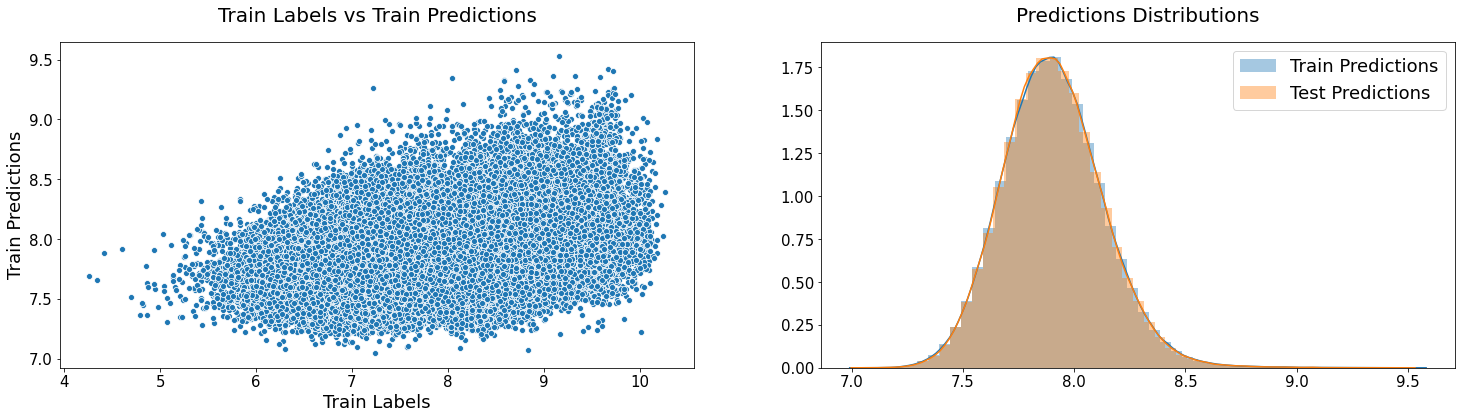

In [8]:
TRAIN_LGB = False

if TRAIN_LGB:
    model = 'LGB'
    lgb_preprocessor = Preprocessor(train=df_train, test=df_test,
                                    n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=None,
                                    create_features=False, discretize_features=False)
    df_train_lgb, df_test_lgb = lgb_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_lgb.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_lgb.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_lgb.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_lgb.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_lgb = df_train_lgb.copy(deep=True)
    y_train_lgb = df_train_lgb[target].copy(deep=True)
    X_test_lgb = df_test_lgb.copy(deep=True)

    lgb_parameters = {
        'predictors': continuous_features,
        'target': target,
        'model': model,
        'model_parameters': {
            'num_leaves': 2 ** 8, 
            'learning_rate': 0.001,
            'bagging_fraction': 0.6,
            'bagging_freq': 3,
            'feature_fraction': 0.5,
            'feature_fraction_bynode': 0.8,
            'min_data_in_leaf': 100,
            'min_data_per_group': 1,            
            'min_gain_to_split': 0.001,
            'lambda_l1': 6,
            'lambda_l2': 0.0005,
            'max_bin': 768,
            'max_depth': -1,
            'objective': 'regression',
            'seed': None,
            'feature_fraction_seed': None,
            'bagging_seed': None,
            'drop_seed': None,
            'data_random_seed': None,
            'boosting_type': 'gbdt',
            'verbose': 1,
            'metric': 'rmse',
            'n_jobs': -1,
        },
        'boosting_rounds': 20000,
        'early_stopping_rounds': 200,
        'seeds': [541992, 721991, 1337]
    }

    lgb_model = TreeModels(**lgb_parameters)
    lgb_model.run(X_train_lgb, y_train_lgb, X_test_lgb)

    del df_train_lgb, df_test_lgb, X_train_lgb, y_train_lgb, X_test_lgb
    del lgb_preprocessor, lgb_parameters, lgb_model
    
    print('Saving LightGBM OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'LGBPredictions']].to_csv('lgb_oof_predictions.csv', index=False)
    df_test_processed[['id', 'LGBPredictions']].to_csv('lgb_test_predictions.csv', index=False)
    
else:
    print('Loading LightGBM OOF and Test predictions from current working directory.')
    df_train_processed['LGBPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/lgb_oof_predictions.csv')['LGBPredictions']
    df_test_processed['LGBPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/lgb_test_predictions.csv')['LGBPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['LGBPredictions'], squared=False)
    print(f'LGB OOF RMSE: {oof_score:.6}')
    TreeModels._plot_predictions(None, df_train_processed[target], df_train_processed['LGBPredictions'], df_test_processed['LGBPredictions'])
    

### 4.2 CatBoost

Loading CatBoost OOF and Test predictions from current working directory.
CB OOF RMSE: 0.697037


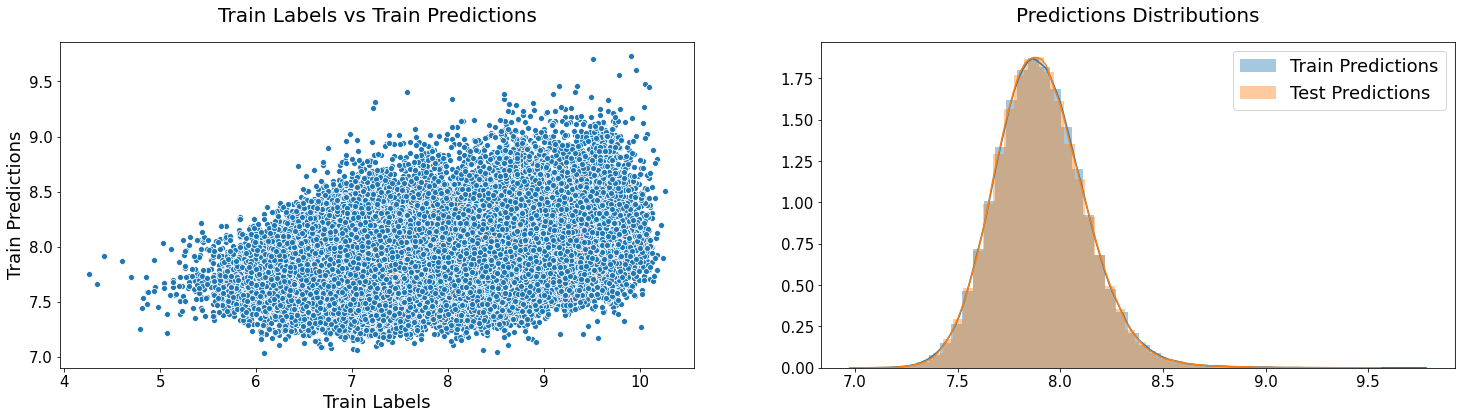

In [9]:
TRAIN_CB = False

if TRAIN_CB:
    model = 'CB'
    cb_preprocessor = Preprocessor(train=df_train, test=df_test,
                                   n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=None,
                                   create_features=False, discretize_features=False)
    df_train_cb, df_test_cb = cb_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_cb.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_cb.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_cb.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_cb.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_cb = df_train_cb[continuous_features + ['fold']].copy(deep=True)
    y_train_cb = df_train_cb[target].copy(deep=True)
    X_test_cb = df_test_cb[continuous_features].copy(deep=True)

    cb_parameters = {
        'predictors': continuous_features,
        'target': target,
        'model': model,
        'model_parameters': {
            'n_estimators': 20000, 
            'learning_rate': 0.006,
            'depth': 10,
            'subsample': 0.8,
            'colsample_bylevel': 0.5,
            'l2_leaf_reg': 0.1,
            'metric_period': 1000,
            'boost_from_average': True,
            'use_best_model': True,
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',   
            'od_type': 'Iter',
            'od_wait': 200,
            'random_seed': None,
            'verbose': 1,
        },
        'boosting_rounds': None,
        'early_stopping_rounds': None,
        'seeds': [541992, 721991, 1337, 42, 0]
    }

    cb_model = TreeModels(**cb_parameters)
    cb_model.run(X_train_cb, y_train_cb, X_test_cb)
    
    del df_train_cb, df_test_cb, X_train_cb, y_train_cb, X_test_cb
    del cb_preprocessor, cb_parameters, cb_model
    
    print('Saving CatBoost OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'CBPredictions']].to_csv('cb_oof_predictions.csv', index=False)
    df_test_processed[['id', 'CBPredictions']].to_csv('cb_test_predictions.csv', index=False)
    
else:
    print('Loading CatBoost OOF and Test predictions from current working directory.')
    df_train_processed['CBPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/cb_oof_predictions.csv')['CBPredictions']
    df_test_processed['CBPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/cb_test_predictions.csv')['CBPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['CBPredictions'], squared=False)
    print(f'CB OOF RMSE: {oof_score:.6}')
    TreeModels._plot_predictions(None, df_train_processed[target], df_train_processed['CBPredictions'], df_test_processed['CBPredictions'])


### 4.3 XGBoost

Loading XGBoost OOF and Test predictions from current working directory.
XGB OOF RMSE: 0.695752


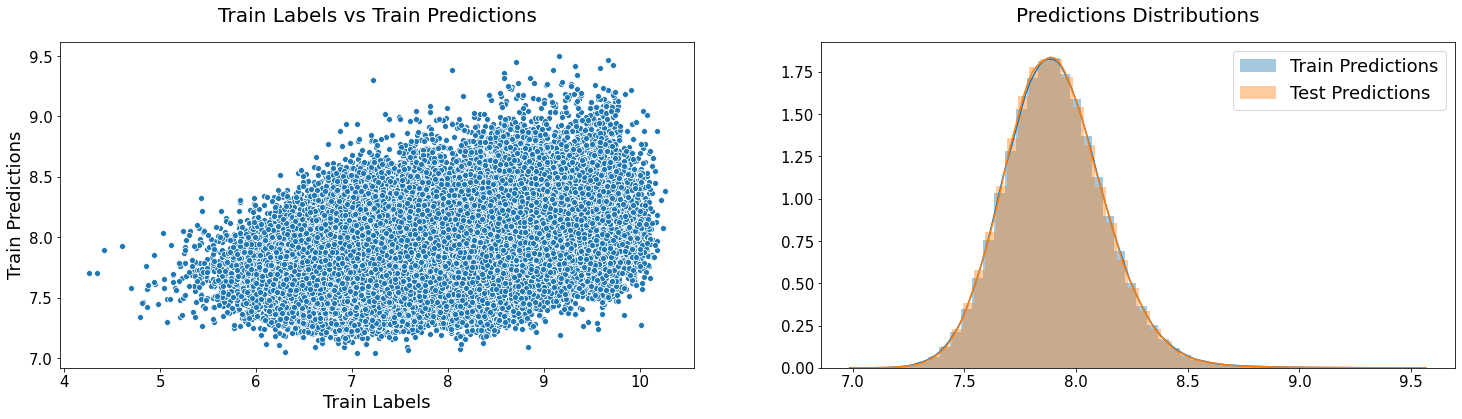

In [10]:
TRAIN_XGB = False

if TRAIN_XGB:
    model = 'XGB'
    xgb_preprocessor = Preprocessor(train=df_train, test=df_test,
                                    n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=None,
                                    create_features=False, discretize_features=False)
    df_train_xgb, df_test_xgb = xgb_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_xgb.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_xgb.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_xgb.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_xgb.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_xgb = df_train_xgb[continuous_features + ['fold']].copy(deep=True)
    y_train_xgb = df_train_xgb[target].copy(deep=True)
    X_test_xgb = df_test_xgb[continuous_features].copy(deep=True)

    xgb_parameters = {
        'predictors': continuous_features,
        'target': target,
        'model': model,
        'model_parameters': {
            'learning_rate': 0.002,
            'colsample_bytree': 0.6, 
            'colsample_bylevel': 0.6,
            'colsample_bynode': 0.6,
            'sumbsample': 0.8,
            'max_depth': 14,
            'gamma': 0,
            'min_child_weight': 200,
            'lambda': 0,
            'alpha': 0,
            'objective': 'reg:squarederror',
            'seed': None,
            'boosting_type': 'gbtree',
            'tree_method': 'gpu_hist',
            'silent': True,
            'verbose': 1,
            'n_jobs': -1,
        },
        'boosting_rounds': 25000,
        'early_stopping_rounds': 200,
        'seeds': [541992, 721991, 1337]
    }

    xgb_model = TreeModels(**xgb_parameters)
    xgb_model.run(X_train_xgb, y_train_xgb, X_test_xgb)

    del df_train_xgb, df_test_xgb, X_train_xgb, y_train_xgb, X_test_xgb
    del xgb_preprocessor, xgb_parameters, xgb_model
    
    print('Saving XGBoost OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'XGBPredictions']].to_csv('xgb_oof_predictions.csv', index=False)
    df_test_processed[['id', 'XGBPredictions']].to_csv('xgb_test_predictions.csv', index=False)
    
else:
    print('Loading XGBoost OOF and Test predictions from current working directory.')
    df_train_processed['XGBPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/xgb_oof_predictions.csv')['XGBPredictions']
    df_test_processed['XGBPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/xgb_test_predictions.csv')['XGBPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['XGBPredictions'], squared=False)
    print(f'XGB OOF RMSE: {oof_score:.6}')
    TreeModels._plot_predictions(None, df_train_processed[target], df_train_processed['XGBPredictions'], df_test_processed['XGBPredictions'])


### 4.4 Random Forest

Loading RandomForest OOF and Test predictions from current working directory.
RF OOF RMSE: 0.706454


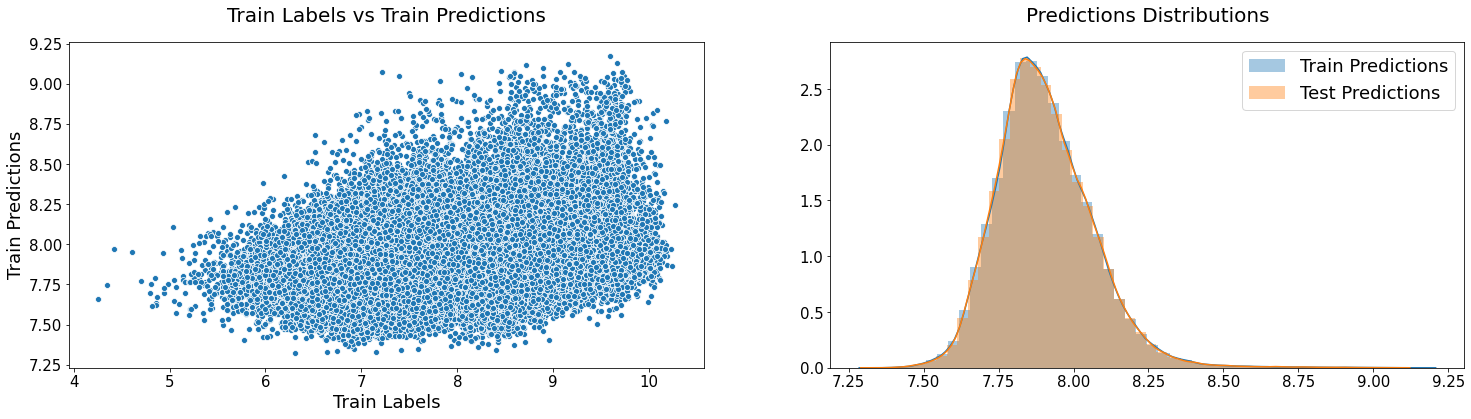

In [11]:
TRAIN_RF = False

if TRAIN_RF:
    model = 'RF'
    rf_preprocessor = Preprocessor(train=df_train, test=df_test,
                                   n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=None,
                                   create_features=False, discretize_features=False)
    df_train_rf, df_test_rf = rf_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_rf.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_rf.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_rf.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_rf.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_rf = df_train_rf[continuous_features + ['fold']].copy(deep=True)
    y_train_rf = df_train_rf[target].copy(deep=True)
    X_test_rf = df_test_rf[continuous_features].copy(deep=True)

    rf_parameters = {
        'predictors': continuous_features,
        'target': target,
        'model': model,
        'model_parameters': {
            'n_estimators': 400,
            'split_algo': 0,
            'split_criterion': 2,             
            'bootstrap': True,
            'bootstrap_features': False,
            'max_depth': 13,
            'max_leaves': -1,
            'max_features': 0.5,
            'n_bins': 2 ** 6,
            'random_state': None,
            'verbose': True,
        },
        'boosting_rounds': None,
        'early_stopping_rounds': None,
        'seeds': [541992, 721991, 1337, 42, 0]
    }

    rf_model = TreeModels(**rf_parameters)
    rf_model.run(X_train_rf, y_train_rf, X_test_rf)

    del df_train_rf, df_test_rf, X_train_rf, y_train_rf, X_test_rf
    del rf_preprocessor, rf_parameters, rf_model
    
    print('Saving RandomForest OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'RFPredictions']].to_csv('rf_oof_predictions.csv', index=False)
    df_test_processed[['id', 'RFPredictions']].to_csv('rf_test_predictions.csv', index=False)
    
else:
    print('Loading RandomForest OOF and Test predictions from current working directory.')
    df_train_processed['RFPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/rf_oof_predictions.csv')['RFPredictions']
    df_test_processed['RFPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/rf_test_predictions.csv')['RFPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['RFPredictions'], squared=False)
    print(f'RF OOF RMSE: {oof_score:.6}')
    TreeModels._plot_predictions(None, df_train_processed[target], df_train_processed['RFPredictions'], df_test_processed['RFPredictions'])


## 5. Linear Models

2 linear models are used in the ensemble and they are Ridge Regression and SVM. Ridge is fitted to very high dimensional sparse features extracted by RandomTreesEmbedding, but can't be used on SVM because `cuml.SVM` doesn't support `scipy.sparse.csr_matrix` format. Even though the training logs are not present in this version of the notebook, those are the parameters used for getting the scores displayed below each cell.

In [12]:
class LinearModels:
    
    def __init__(self, predictors, target, model, model_parameters):
        
        self.predictors = predictors
        self.target = target
               
        self.model = model
        self.model_parameters = model_parameters       
                
    def _train_and_predict_ridge_regression(self, X_train, y_train, X_test):
                
        X = pd.concat([X_train[continuous_features], X_test[continuous_features]], ignore_index=True, axis=0)
        embedder = RandomTreesEmbedding(n_estimators=800,
                                        max_depth=8,
                                        min_samples_split=100,
                                        n_jobs=-1,
                                        random_state=0, 
                                        verbose=False)
        embedder.fit(X)        
        del X
        X_test = embedder.transform(X_test.loc[:, continuous_features]).astype(np.uint8)
                        
        oof_predictions = np.zeros(X_train.shape[0])
        test_predictions = np.zeros(X_test.shape[0])
        
        for fold in sorted(X_train['fold'].unique()):
            
            trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index

            X_trn = embedder.transform(X_train.loc[trn_idx, continuous_features]).astype(np.uint8)
            y_trn = y_train.loc[trn_idx]
            X_val = embedder.transform(X_train.loc[val_idx, continuous_features]).astype(np.uint8)
            y_val = y_train.loc[val_idx]
            
            model = Ridge(**self.model_parameters)
            model.fit(X_trn, y_trn)
            
            val_predictions = model.predict(X_val)
            oof_predictions[val_idx] += val_predictions
            fold_test_predictions = model.predict(X_test)
            test_predictions += (fold_test_predictions / X_train['fold'].nunique())
                        
            fold_score = mean_squared_error(y_val, val_predictions, squared=False)
            print(f'RR Fold {int(fold)} - X_trn: {X_trn.shape} X_val: {X_val.shape} - Score: {fold_score:.6}')
            
        df_train_processed['RRPredictions'] = oof_predictions
        df_test_processed['RRPredictions'] = test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['RRPredictions'], squared=False)
        print(f'{"-" * 30}\nRR OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        
        self._plot_predictions(df_train_processed[target], df_train_processed['RRPredictions'], df_test_processed['RRPredictions'])
            
    def _train_and_predict_svm(self, X_train, y_train, X_test):
        
        oof_predictions = np.zeros(X_train.shape[0])
        test_predictions = np.zeros(X_test.shape[0])
        
        for fold in sorted(X_train['fold'].unique()):
            
            trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index

            X_trn = X_train.loc[trn_idx, self.predictors]
            y_trn = y_train.loc[trn_idx]
            X_val = X_train.loc[val_idx, self.predictors]
            y_val = y_train.loc[val_idx]

            import cuml
            model = cuml.SVR(**self.model_parameters)
            model.fit(X_trn, y_trn)
            
            val_predictions = model.predict(X_val)
            oof_predictions[val_idx] += val_predictions
            fold_test_predictions = model.predict(X_test)
            test_predictions += (fold_test_predictions / X_train['fold'].nunique())
            
            fold_score = mean_squared_error(y_val, val_predictions, squared=False)
            print(f'SVM Fold {int(fold)} - X_trn: {X_trn.shape} X_val: {X_val.shape} - Score: {fold_score:.6}')
            
        df_train_processed['SVMPredictions'] = oof_predictions
        df_test_processed['SVMPredictions'] = test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['SVMPredictions'], squared=False)
        print(f'{"-" * 30}\nSVM OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        
        self._plot_predictions(df_train_processed[target], df_train_processed['SVMPredictions'], df_test_processed['SVMPredictions'])
        
    def _plot_predictions(self, train_labels, train_predictions, test_predictions):
        
        fig, axes = plt.subplots(ncols=2, figsize=(25, 6))                                            
        sns.scatterplot(train_labels, train_predictions, ax=axes[0])
        sns.distplot(train_predictions, label='Train Predictions', ax=axes[1])
        sns.distplot(test_predictions, label='Test Predictions', ax=axes[1])

        axes[0].set_xlabel(f'Train Labels', size=18)
        axes[0].set_ylabel(f'Train Predictions', size=18)
        axes[1].set_xlabel('')
        axes[1].legend(prop={'size': 18})
        for i in range(2):
            axes[i].tick_params(axis='x', labelsize=15)
            axes[i].tick_params(axis='y', labelsize=15)
        axes[0].set_title(f'Train Labels vs Train Predictions', size=20, pad=20)
        axes[1].set_title(f'Predictions Distributions', size=20, pad=20)
            
        plt.show() 
            
    def run(self, X_train, y_train, X_test):
        
        if self.model == 'Ridge':
            self._train_and_predict_ridge_regression(X_train, y_train, X_test)
        elif self.model == 'SVM':
            self._train_and_predict_svm(X_train, y_train, X_test)


### 5.1 Ridge Regression

Loading RidgeRegression OOF and Test predictions from current working directory.
RR OOF RMSE: 0.700054


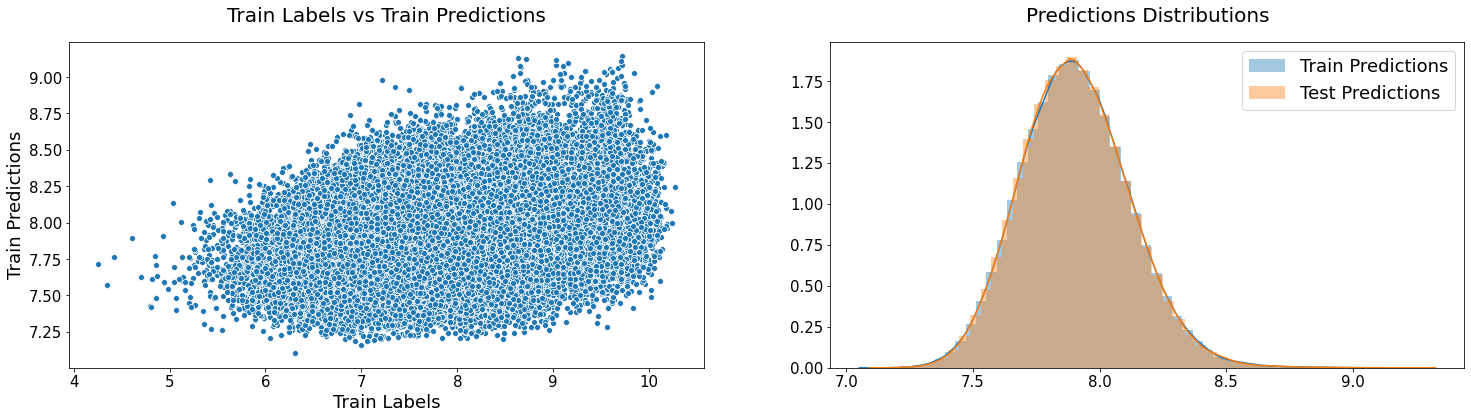

In [13]:
FIT_RR = False

if FIT_RR:
    model = 'Ridge'
    ridge_preprocessor = Preprocessor(train=df_train, test=df_test,
                                      n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=None,
                                      create_features=False, discretize_features=False)
    df_train_ridge, df_test_ridge = ridge_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_ridge.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_ridge.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_ridge.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_ridge.memory_usage().sum() / 1024 ** 2:.2f} MB\n')
    
    X_train_rr = df_train_ridge[continuous_features + ['fold']].copy(deep=True)
    y_train_rr = df_train_ridge[target].copy(deep=True)
    X_test_rr = df_test_ridge[continuous_features].copy(deep=True)
    
    ridge_parameters = {
        'predictors': continuous_features,
        'target': target,
        'model': model,
        'model_parameters': {
            'alpha': 7000
        }
    }

    ridge_model = LinearModels(**ridge_parameters)
    ridge_model.run(X_train_rr, y_train_rr, X_test_rr)

    del df_train_ridge, df_test_ridge, X_train_ridge, y_train_ridge, X_test_ridge
    del ridge_preprocessor, ridge_parameters, ridge_model
    
    print('Saving RidgeRegression OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'RRPredictions']].to_csv('rr_oof_predictions.csv', index=False)
    df_test_processed[['id', 'RRPredictions']].to_csv('rr_test_predictions.csv', index=False)
    
else:
    print('Loading RidgeRegression OOF and Test predictions from current working directory.')
    df_train_processed['RRPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/rr_oof_predictions.csv')['RRPredictions']
    df_test_processed['RRPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/rr_test_predictions.csv')['RRPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['RRPredictions'], squared=False)
    print(f'RR OOF RMSE: {oof_score:.6}')
    LinearModels._plot_predictions(None, df_train_processed[target], df_train_processed['RRPredictions'], df_test_processed['RRPredictions'])


### 5.2 SVM

Loading SVM OOF and Test predictions from current working directory.
SVM OOF RMSE: 0.714877


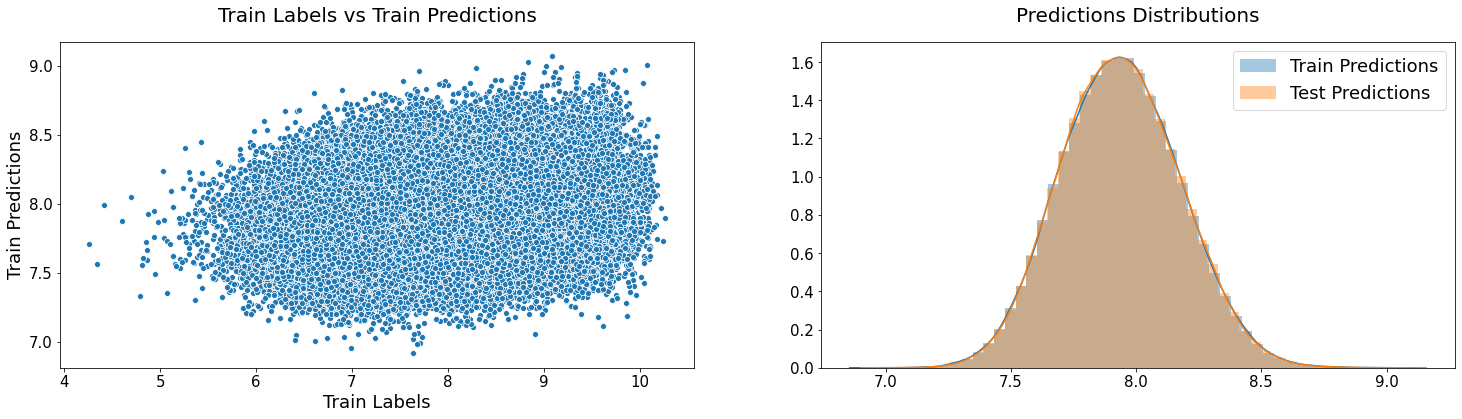

In [14]:
FIT_SVM = False

if FIT_SVM:
    model = 'SVM'
    svm_preprocessor = Preprocessor(train=df_train, test=df_test,
                                    n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=StandardScaler,
                                    create_features=False, discretize_features=True)
    df_train_svm, df_test_svm = svm_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_svm.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_svm.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_svm.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_svm.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_svm = df_train_svm[continuous_features + ['fold'] + [f'{cont}_class' for cont in continuous_features]].copy(deep=True)
    y_train_svm = df_train_svm[target].copy(deep=True)
    X_test_svm = df_test_svm[continuous_features + [f'{cont}_class' for cont in continuous_features]].copy(deep=True)
    
    svm_parameters = {
        'predictors': continuous_features + [f'{cont}_class' for cont in continuous_features],
        'target': target,
        'model': model,
        'model_parameters': {
            'C': 0.5
        }
    }

    svm_model = LinearModels(**svm_parameters)
    svm_model.run(X_train_svm, y_train_svm, X_test_svm)

    del df_train_svm, df_test_svm, X_train_svm, y_train_svm, X_test_svm
    del svm_preprocessor, svm_parameters, svm_model
    
    print('Saving SVM OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'SVMPredictions']].to_csv('svm_oof_predictions.csv', index=False)
    df_test_processed[['id', 'SVMPredictions']].to_csv('svm_test_predictions.csv', index=False)
    
else:
    print('Loading SVM OOF and Test predictions from current working directory.')
    df_train_processed['SVMPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/svm_oof_predictions.csv')['SVMPredictions']
    df_test_processed['SVMPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/svm_test_predictions.csv')['SVMPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['SVMPredictions'], squared=False)
    print(f'SVM OOF RMSE: {oof_score:.6}')
    LinearModels._plot_predictions(None, df_train_processed[target], df_train_processed['SVMPredictions'], df_test_processed['SVMPredictions'])


## 6. Neural Networks

In [15]:
class NeuralNetworks:
    
    def __init__(self, predictors, target, model, model_parameters, seeds):
        
        self.predictors = predictors
        self.target = target
               
        self.model = model
        self.model_parameters = model_parameters
        self.seeds = seeds
                
    def _set_seed(self, seed):
        
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
                
    def _rmse_loss(self, y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
        
    def _dense_block(self, x, units, activation, dropout_rate, kernel_regularizer, batch_normalization, weight_normalization, gaussian_noise):
        
        if weight_normalization:
            x = tfa.layers.WeightNormalization(Dense(units=units, activation=activation, kernel_regularizer=kernel_regularizer))(x)
        else:
            x = Dense(units=units, activation=activation, kernel_regularizer=kernel_regularizer)(x)
            
        if batch_normalization:
            x = BatchNormalization()(x)
        if dropout_rate > 0:
            x = Dropout(rate=dropout_rate)(x)
        if gaussian_noise > 0:
            x = GaussianNoise(gaussian_noise)(x)
            
        return x
    
    def _get_tmlp(self, input_shape, output_shape):        
        
        inputs = []
        
        cont1_discretized_input = Input(shape=(1, ), name='cont1_discretized_input')
        cont1_embedding_dim = 2
        cont1_discretized_embedding = Embedding(input_dim=4, output_dim=cont1_embedding_dim, input_length=1, name='cont1_discretized_embedding')(cont1_discretized_input)
        cont1_discretized_embedding = Reshape(target_shape=(cont1_embedding_dim, ))(cont1_discretized_embedding)
        inputs.append(cont1_discretized_embedding)
        
        cont2_discretized_input = Input(shape=(1, ), name='cont2_discretized_input')
        cont2_embedding_dim = 4
        cont2_discretized_embedding = Embedding(input_dim=10, output_dim=cont2_embedding_dim, input_length=1, name='cont2_discretized_embedding')(cont2_discretized_input)
        cont2_discretized_embedding = Reshape(target_shape=(cont2_embedding_dim, ))(cont2_discretized_embedding)
        inputs.append(cont2_discretized_embedding)
        
        cont3_discretized_input = Input(shape=(1, ), name='cont3_discretized_input')
        cont3_embedding_dim = 3
        cont3_discretized_embedding = Embedding(input_dim=6, output_dim=cont3_embedding_dim, input_length=1, name='cont3_discretized_embedding')(cont3_discretized_input)
        cont3_discretized_embedding = Reshape(target_shape=(cont3_embedding_dim, ))(cont3_discretized_embedding)
        inputs.append(cont3_discretized_embedding)
        
        cont4_discretized_input = Input(shape=(1, ), name='cont4_discretized_input')
        cont4_embedding_dim = 2
        cont4_discretized_embedding = Embedding(input_dim=4, output_dim=cont4_embedding_dim, input_length=1, name='cont4_discretized_embedding')(cont4_discretized_input)
        cont4_discretized_embedding = Reshape(target_shape=(cont4_embedding_dim, ))(cont4_discretized_embedding)
        inputs.append(cont4_discretized_embedding)
        
        cont5_discretized_input = Input(shape=(1, ), name='cont5_discretized_input')
        cont5_embedding_dim = 2
        cont5_discretized_embedding = Embedding(input_dim=3, output_dim=cont5_embedding_dim, input_length=1, name='cont5_discretized_embedding')(cont5_discretized_input)
        cont5_discretized_embedding = Reshape(target_shape=(cont5_embedding_dim, ))(cont5_discretized_embedding)
        inputs.append(cont5_discretized_embedding)
        
        cont6_discretized_input = Input(shape=(1, ), name='cont6_discretized_input')
        cont6_embedding_dim = 2
        cont6_discretized_embedding = Embedding(input_dim=2, output_dim=cont6_embedding_dim, input_length=1, name='cont6_discretized_embedding')(cont6_discretized_input)
        cont6_discretized_embedding = Reshape(target_shape=(cont6_embedding_dim, ))(cont6_discretized_embedding)
        inputs.append(cont6_discretized_embedding)
        
        cont7_discretized_input = Input(shape=(1, ), name='cont7_discretized_input')
        cont7_embedding_dim = 2
        cont7_discretized_embedding = Embedding(input_dim=3, output_dim=cont7_embedding_dim, input_length=1, name='cont7_discretized_embedding')(cont7_discretized_input)
        cont7_discretized_embedding = Reshape(target_shape=(cont7_embedding_dim, ))(cont7_discretized_embedding)
        inputs.append(cont7_discretized_embedding)
        
        cont8_discretized_input = Input(shape=(1, ), name='cont8_discretized_input')
        cont8_embedding_dim = 2
        cont8_discretized_embedding = Embedding(input_dim=4, output_dim=cont8_embedding_dim, input_length=1, name='cont8_discretized_embedding')(cont8_discretized_input)
        cont8_discretized_embedding = Reshape(target_shape=(cont8_embedding_dim, ))(cont8_discretized_embedding)
        inputs.append(cont8_discretized_embedding)
        
        cont9_discretized_input = Input(shape=(1, ), name='cont9_discretized_input')
        cont9_embedding_dim = 2
        cont9_discretized_embedding = Embedding(input_dim=4, output_dim=cont9_embedding_dim, input_length=1, name='cont9_discretized_embedding')(cont9_discretized_input)
        cont9_discretized_embedding = Reshape(target_shape=(cont9_embedding_dim, ))(cont9_discretized_embedding)
        inputs.append(cont9_discretized_embedding)
        
        cont10_discretized_input = Input(shape=(1, ), name='cont10_discretized_input')
        cont10_embedding_dim = 3
        cont10_discretized_embedding = Embedding(input_dim=8, output_dim=cont10_embedding_dim, input_length=1, name='cont10_discretized_embedding')(cont10_discretized_input)
        cont10_discretized_embedding = Reshape(target_shape=(cont10_embedding_dim, ))(cont10_discretized_embedding)
        inputs.append(cont10_discretized_embedding)
        
        cont11_discretized_input = Input(shape=(1, ), name='cont11_discretized_input')
        cont11_embedding_dim = 3
        cont11_discretized_embedding = Embedding(input_dim=5, output_dim=cont11_embedding_dim, input_length=1, name='cont11_discretized_embedding')(cont11_discretized_input)
        cont11_discretized_embedding = Reshape(target_shape=(cont11_embedding_dim, ))(cont11_discretized_embedding)
        inputs.append(cont11_discretized_embedding)
        
        cont12_discretized_input = Input(shape=(1, ), name='cont12_discretized_input')
        cont12_embedding_dim = 2
        cont12_discretized_embedding = Embedding(input_dim=4, output_dim=cont12_embedding_dim, input_length=1, name='cont12_discretized_embedding')(cont12_discretized_input)
        cont12_discretized_embedding = Reshape(target_shape=(cont12_embedding_dim, ))(cont12_discretized_embedding)
        inputs.append(cont12_discretized_embedding)
        
        cont13_discretized_input = Input(shape=(1, ), name='cont13_discretized_input')
        cont13_embedding_dim = 3
        cont13_discretized_embedding = Embedding(input_dim=6, output_dim=cont13_embedding_dim, input_length=1, name='cont13_discretized_embedding')(cont13_discretized_input)
        cont13_discretized_embedding = Reshape(target_shape=(cont13_embedding_dim, ))(cont13_discretized_embedding)
        inputs.append(cont13_discretized_embedding)
        
        cont14_discretized_input = Input(shape=(1, ), name='cont14_discretized_input')
        cont14_embedding_dim = 3
        cont14_discretized_embedding = Embedding(input_dim=6, output_dim=cont14_embedding_dim, input_length=1, name='cont14_discretized_embedding')(cont14_discretized_input)
        cont14_discretized_embedding = Reshape(target_shape=(cont14_embedding_dim, ))(cont14_discretized_embedding)
        inputs.append(cont14_discretized_embedding)
        
        continuous_inputs = Input(shape=(14, ), name='continuous_inputs')
        inputs.append(continuous_inputs)
        
        sparse_inputs = Input(shape=(input_shape - (14 * 2), ), name='sparse_inputs')
        inputs.append(sparse_inputs)
        
        x = Concatenate()(inputs)
        x = self._dense_block(x, units=256, activation='elu', dropout_rate=0.50, kernel_regularizer=None, batch_normalization=True, weight_normalization=True, gaussian_noise=0.01)        
        x = self._dense_block(x, units=256, activation='elu', dropout_rate=0.50, kernel_regularizer=None, batch_normalization=True, weight_normalization=True, gaussian_noise=0.01)        
        outputs = Dense(output_shape, activation='linear')(x)
        
        model = Model(inputs=[continuous_inputs,
                              cont1_discretized_input,
                              cont2_discretized_input,
                              cont3_discretized_input,
                              cont4_discretized_input,
                              cont5_discretized_input,
                              cont6_discretized_input,
                              cont7_discretized_input,
                              cont8_discretized_input,
                              cont9_discretized_input,
                              cont10_discretized_input,
                              cont11_discretized_input,
                              cont12_discretized_input,
                              cont13_discretized_input,
                              cont14_discretized_input, 
                              sparse_inputs],
                      outputs=outputs,
                      name='TMLP')                
        
        optimizer = tfa.optimizers.AdamW(learning_rate=self.model_parameters['learning_rate'], weight_decay=self.model_parameters['weight_decay'])          
        model.compile(optimizer=optimizer, loss=self._rmse_loss, metrics=None)
        
        return model
    
    def _get_rmlp(self, input_shape, output_shape):
        
        inputs = Input(shape=(input_shape, ), name='inputs')
        x = self._dense_block(inputs, units=128, activation='elu', dropout_rate=0.30, kernel_regularizer=None, batch_normalization=True, weight_normalization=False, gaussian_noise=0)        
        x = self._dense_block(x, units=128, activation='elu', dropout_rate=0.30, kernel_regularizer=None, batch_normalization=True, weight_normalization=False, gaussian_noise=0)        
        outputs = Dense(output_shape, activation='linear')(x)
        
        model = Model(inputs=inputs, outputs=outputs, name='RMLP')                
        
        optimizer = Adam(learning_rate=self.model_parameters['learning_rate'])          
        model.compile(optimizer=optimizer, loss=self._rmse_loss, metrics=None)
        
        return model
        
    def train_and_predict_tmlp(self, X_train, y_train, X_test):
        
        all_model_histories = {}
        seed_avg_oof_predictions = np.zeros(X_train.shape[0])
        seed_avg_test_predictions = np.zeros(X_test.shape[0])
                                        
        oof_predictions = np.zeros(X_train.shape[0])
        test_predictions = np.zeros(X_test.shape[0])
        
        for seed in self.seeds:
            
            X = pd.concat([X_train[continuous_features], X_test[continuous_features]], ignore_index=True, axis=0)
            embedder = RandomTreesEmbedding(n_estimators=300,
                                            max_depth=3,
                                            min_samples_split=100,
                                            n_jobs=-1,
                                            random_state=seed, 
                                            verbose=True)
            embedder.fit(X)        
            del X

            train_sparse_features = embedder.transform(X_train.loc[:, continuous_features]).astype(np.uint8).toarray()
            X_train = pd.concat([X_train, pd.DataFrame(train_sparse_features)], axis=1)
            sparse_feature_columns = list(np.arange(train_sparse_features.shape[1]))
            self.predictors += sparse_feature_columns
            del train_sparse_features

            test_sparse_features = embedder.transform(X_test.loc[:, continuous_features]).astype(np.uint8).toarray()
            del embedder
            X_test = pd.concat([X_test, pd.DataFrame(test_sparse_features)], axis=1)
            del test_sparse_features

            print(f'{"-" * 30}\nRunning TMLP model with seed: {seed}\n{"-" * 30}\n')
            self._set_seed(seed)
            model_histories = []
        
            for fold in sorted(X_train['fold'].unique()):

                trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index
                X_trn, y_trn = X_train.loc[trn_idx, self.predictors], y_train.loc[trn_idx]
                X_val, y_val = X_train.loc[val_idx, self.predictors], y_train.loc[val_idx]

                model = self._get_mlp(input_shape=X_trn.shape[1], output_shape=1)
                reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                              factor=self.model_parameters['reduce_lr_factor'],
                                              patience=self.model_parameters['reduce_lr_patience'],
                                              min_lr=self.model_parameters['reduce_lr_min'],
                                              mode='min',
                                              verbose=True)
                early_stopping = EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               min_delta=self.model_parameters['early_stopping_min_delta'],
                                               patience=self.model_parameters['early_stopping_patience'],
                                               restore_best_weights=True, 
                                               verbose=True)
                
                history = model.fit([X_trn[self.predictors[:14]],
                                     X_trn['cont1_class'],
                                     X_trn['cont2_class'],
                                     X_trn['cont3_class'],
                                     X_trn['cont4_class'],
                                     X_trn['cont5_class'],
                                     X_trn['cont6_class'],
                                     X_trn['cont7_class'],
                                     X_trn['cont8_class'],
                                     X_trn['cont9_class'],
                                     X_trn['cont10_class'],
                                     X_trn['cont11_class'],
                                     X_trn['cont12_class'],
                                     X_trn['cont13_class'],
                                     X_trn['cont14_class'], 
                                     X_trn[sparse_feature_columns]],
                                    y_trn,
                                    validation_data=([X_val[self.predictors[:14]],
                                                      X_val['cont1_class'],
                                                      X_val['cont2_class'],
                                                      X_val['cont3_class'],
                                                      X_val['cont4_class'],
                                                      X_val['cont5_class'],
                                                      X_val['cont6_class'],
                                                      X_val['cont7_class'],
                                                      X_val['cont8_class'],
                                                      X_val['cont9_class'],
                                                      X_val['cont10_class'],
                                                      X_val['cont11_class'],
                                                      X_val['cont12_class'],
                                                      X_val['cont13_class'],
                                                      X_val['cont14_class'], 
                                                      X_val[sparse_feature_columns]],
                                                     y_val),
                                    epochs=self.model_parameters['epochs'], 
                                    batch_size=self.model_parameters['batch_size'],
                                    callbacks=[reduce_lr, early_stopping],
                                    verbose=True)

                val_predictions = model.predict([X_val[self.predictors[:14]],
                                                 X_val['cont1_class'],
                                                 X_val['cont2_class'],
                                                 X_val['cont3_class'],
                                                 X_val['cont4_class'],
                                                 X_val['cont5_class'],
                                                 X_val['cont6_class'],
                                                 X_val['cont7_class'],
                                                 X_val['cont8_class'],
                                                 X_val['cont9_class'],
                                                 X_val['cont10_class'],
                                                 X_val['cont11_class'],
                                                 X_val['cont12_class'],
                                                 X_val['cont13_class'],
                                                 X_val['cont14_class'],
                                                 X_val[sparse_feature_columns]])
                seed_avg_oof_predictions[val_idx] += (val_predictions.flatten() / len(self.seeds))
                test_predictions = model.predict([X_test[self.predictors[:14]],
                                                  X_test['cont1_class'],
                                                  X_test['cont2_class'],
                                                  X_test['cont3_class'],
                                                  X_test['cont4_class'],
                                                  X_test['cont5_class'],
                                                  X_test['cont6_class'],
                                                  X_test['cont7_class'],
                                                  X_test['cont8_class'],
                                                  X_test['cont9_class'],
                                                  X_test['cont10_class'],
                                                  X_test['cont11_class'],
                                                  X_test['cont12_class'],
                                                  X_test['cont13_class'],
                                                  X_test['cont14_class'],
                                                  X_test[sparse_feature_columns]])
                seed_avg_test_predictions += (test_predictions.flatten() / X_train['fold'].nunique() / len(self.seeds))
                model_histories.append(history)

                fold_score = mean_squared_error(df_train_processed.loc[val_idx, self.target], val_predictions, squared=False)
                print(f'\nTMLP Fold {int(fold)} - X_trn: {X_train.loc[trn_idx, self.predictors].shape} X_val: {X_train.loc[val_idx, self.predictors].shape} - Score: {fold_score:.6} - Seed: {seed}\n')
            
            all_model_histories[seed] = model_histories
            
        df_train_processed['TMLPPredictions'] = seed_avg_oof_predictions
        df_test_processed['TMLPPredictions'] = seed_avg_test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['TMLPPredictions'], squared=False)
        print(f'{"-" * 30}\nTMLP OOF RMSE: {oof_score:.6} ({len(self.seeds)} Seed Average) \n{"-" * 30}')
        
        self._plot_learning_curve(all_model_histories)
        self._plot_predictions(df_train_processed[target], df_train_processed['TMLPPredictions'], df_test_processed['TMLPPredictions'])
        
    def train_and_predict_rmlp(self, X_train, y_train, X_test):
        
        all_model_histories = {}
        seed_avg_oof_predictions = np.zeros(X_train.shape[0])
        seed_avg_test_predictions = np.zeros(X_test.shape[0])
                                        
        oof_predictions = np.zeros(X_train.shape[0])
        test_predictions = np.zeros(X_test.shape[0])
        
        for seed in self.seeds:
            
            print(f'{"-" * 30}\nRunning RMLP model with seed: {seed}\n{"-" * 30}\n')
            self._set_seed(seed)
            model_histories = []
        
            for fold in sorted(X_train['fold'].unique()):

                trn_idx, val_idx = X_train.loc[X_train['fold'] != fold].index, X_train.loc[X_train['fold'] == fold].index
                X_trn, y_trn = X_train.loc[trn_idx, self.predictors], y_train.loc[trn_idx]
                X_val, y_val = X_train.loc[val_idx, self.predictors], y_train.loc[val_idx]

                model = self._get_rmlp(input_shape=X_trn.shape[1], output_shape=1)
                reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                              factor=self.model_parameters['reduce_lr_factor'],
                                              patience=self.model_parameters['reduce_lr_patience'],
                                              min_lr=self.model_parameters['reduce_lr_min'],
                                              mode='min',
                                              verbose=True)
                early_stopping = EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               min_delta=self.model_parameters['early_stopping_min_delta'],
                                               patience=self.model_parameters['early_stopping_patience'],
                                               restore_best_weights=True, 
                                               verbose=True)
                
                history = model.fit(X_trn, y_trn,
                                    validation_data=(X_val, y_val),
                                    epochs=self.model_parameters['epochs'], 
                                    batch_size=self.model_parameters['batch_size'],
                                    callbacks=[reduce_lr, early_stopping],
                                    verbose=True)

                val_predictions = model.predict(X_val)
                seed_avg_oof_predictions[val_idx] += (val_predictions.flatten() / len(self.seeds))
                test_predictions = model.predict(X_test)
                seed_avg_test_predictions += (test_predictions.flatten() / X_train['fold'].nunique() / len(self.seeds))
                model_histories.append(history)

                fold_score = mean_squared_error(df_train_processed.loc[val_idx, self.target], val_predictions.flatten(), squared=False)
                print(f'\nRMLP Fold {int(fold)} - X_trn: {X_train.loc[trn_idx, self.predictors].shape} X_val: {X_train.loc[val_idx, self.predictors].shape} - Score: {fold_score:.6} - Seed: {seed}\n')
            
            all_model_histories[seed] = model_histories
            
        df_train_processed['RMLPPredictions'] = seed_avg_oof_predictions
        df_test_processed['RMLPPredictions'] = seed_avg_test_predictions
        oof_score = mean_squared_error(y_train, df_train_processed['RMLPPredictions'], squared=False)
        print(f'{"-" * 30}\nRMLP OOF RMSE: {oof_score:.6} ({len(self.seeds)} Seed Average) \n{"-" * 30}')
        
        self._plot_learning_curve(all_model_histories)
        self._plot_predictions(df_train_processed[target], df_train_processed['RMLPPredictions'], df_test_processed['RMLPPredictions'])
        
    def _plot_learning_curve(self, all_model_histories):
    
        n_folds = 5
        fig, axes = plt.subplots(nrows=n_folds, figsize=(32, 50), dpi=100)

        for i in range(n_folds):

            for seed, histories in all_model_histories.items():

                axes[i].plot(np.arange(1, len(histories[i].history['loss']) + 1), histories[i].history['loss'], label=f'train_loss (Seed: {seed})', alpha=0.5)
                axes[i].plot(np.arange(1, len(histories[i].history['val_loss']) + 1), histories[i].history['val_loss'], label=f'val_loss (Seed: {seed})', alpha=0.5)    

            axes[i].set_xlabel('Epochs', size=20)
            axes[i].set_ylabel('RMSE', size=20)
            axes[i].set_yscale('log')
            axes[i].tick_params(axis='x', labelsize=20)
            axes[i].tick_params(axis='y', labelsize=20)
            axes[i].legend(prop={'size': 20}) 
            axes[i].set_title(f'Fold {i + 1} Learning Curve', fontsize=20, pad=10)

        plt.show()
        
    def _plot_predictions(self, train_labels, train_predictions, test_predictions):
        
        fig, axes = plt.subplots(ncols=2, figsize=(25, 6))                                            
        sns.scatterplot(train_labels, train_predictions, ax=axes[0])
        sns.distplot(train_predictions, label='Train Predictions', ax=axes[1])
        sns.distplot(test_predictions, label='Test Predictions', ax=axes[1])

        axes[0].set_xlabel(f'Train Labels', size=18)
        axes[0].set_ylabel(f'Train Predictions', size=18)
        axes[1].set_xlabel('')
        axes[1].legend(prop={'size': 18})
        for i in range(2):
            axes[i].tick_params(axis='x', labelsize=15)
            axes[i].tick_params(axis='y', labelsize=15)
        axes[0].set_title(f'Train Labels vs Train Predictions', size=20, pad=20)
        axes[1].set_title(f'Predictions Distributions', size=20, pad=20)
            
        plt.show()


### 6.1 Tree MLP

Loading TMLP OOF and Test predictions from current working directory.
TMLP OOF RMSE: 0.700986


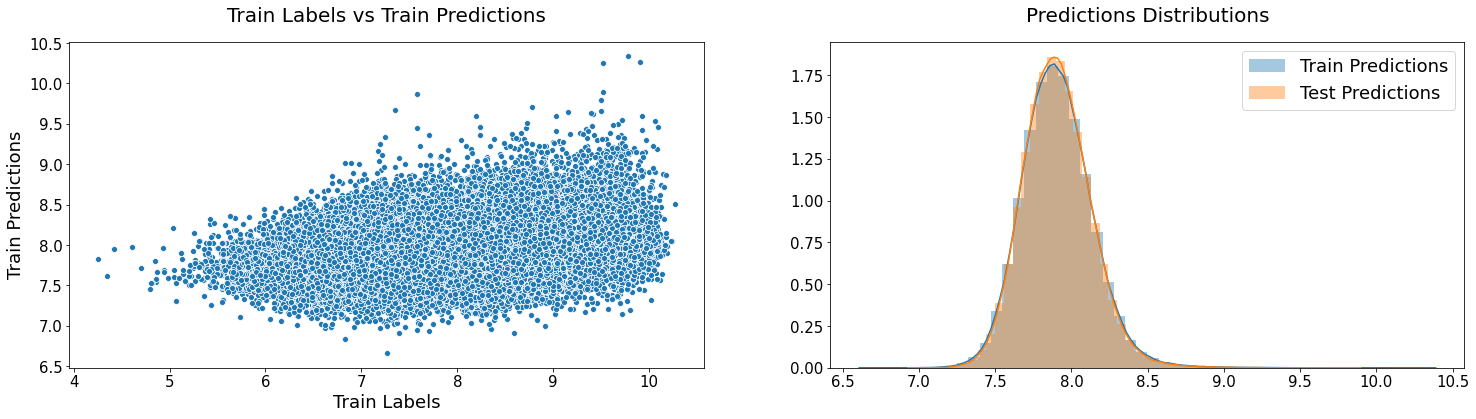

In [16]:
TRAIN_TMLP = False

if TRAIN_TMLP:
    model = 'TMLP'
    tmlp_preprocessor = Preprocessor(train=df_train, test=df_test,
                                     n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=StandardScaler,
                                     create_features=False, discretize_features=True)
    df_train_tmlp, df_test_tmlp = tmlp_preprocessor.transform()

    print(f'\n{model} Training Set Shape = {df_train_tmlp.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_tmlp.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_tmlp.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_tmlp.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_tmlp = df_train_tmlp[continuous_features + ['fold'] + [f'{cont}_class' for cont in continuous_features]].copy(deep=True)
    y_train_tmlp = df_train_tmlp[target].copy(deep=True)
    X_test_tmlp = df_test_tmlp[continuous_features + [f'{cont}_class' for cont in continuous_features]].copy(deep=True)
            
    tmlp_parameters = {        
        'predictors': continuous_features + [f'{cont}_class' for cont in continuous_features],
        'target': target,
        'model': model,
        'model_parameters': {
            'learning_rate': 0.0009,
            'weight_decay': 0.000001,
            'epochs': 150,
            'batch_size': 2 ** 10,
            'reduce_lr_factor': 0.8,
            'reduce_lr_patience': 5,
            'reduce_lr_min': 0.000001,
            'early_stopping_min_delta': 0.0001,
            'early_stopping_patience': 15
        },
        'seeds': [541992]
    }
        
    tmlp_model = NeuralNetworks(**tmlp_parameters)
    tmlp_model.train_and_predict_tmlp(X_train_tmlp, y_train_tmlp, X_test_tmlp)
    
    del df_train_tmlp, df_test_tmlp, X_train_tmlp, y_train_tmlp, X_test_tmlp
    del tmlp_preprocessor, tmlp_parameters, tmlp_model
    
    print('Saving TMLP OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'TMLPPredictions']].to_csv('tmlp_oof_predictions.csv', index=False)
    df_test_processed[['id', 'TMLPPredictions']].to_csv('tmlp_test_predictions.csv', index=False)
    
else:
    print('Loading TMLP OOF and Test predictions from current working directory.')
    df_train_processed['TMLPPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/tmlp_oof_predictions.csv')['MLPPredictions']
    df_test_processed['TMLPPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/tmlp_test_predictions.csv')['MLPPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['TMLPPredictions'], squared=False)
    print(f'TMLP OOF RMSE: {oof_score:.6}')
    NeuralNetworks._plot_predictions(None, df_train_processed[target], df_train_processed['TMLPPredictions'], df_test_processed['TMLPPredictions'])


### 6.1 Raw MLP

Loading RMLP OOF and Test predictions from current working directory.
RMLP OOF RMSE: 0.705433


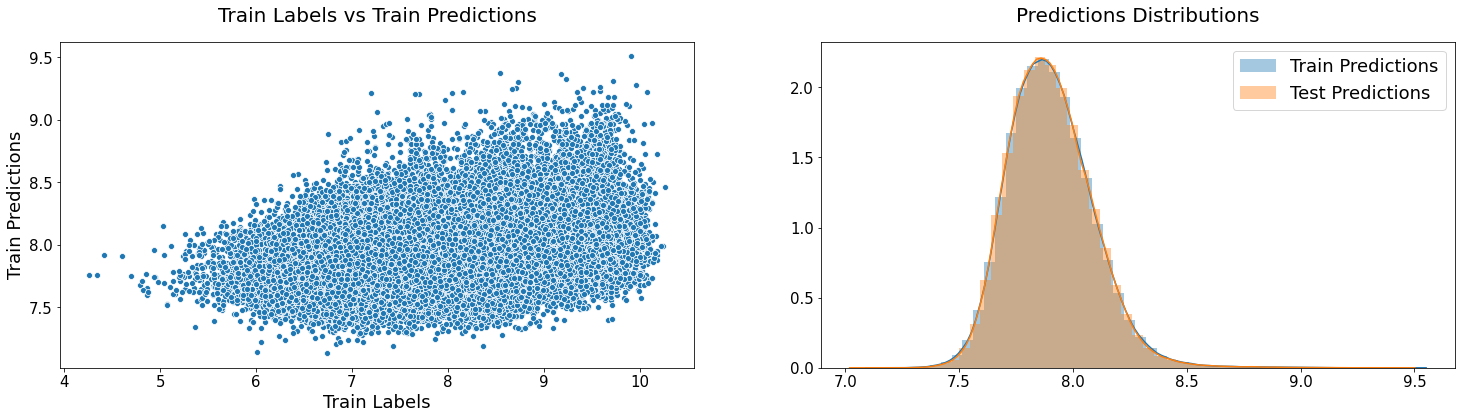

In [17]:
TRAIN_RMLP = False

if TRAIN_RMLP:
    model = 'RMLP'
    rmlp_preprocessor = Preprocessor(train=df_train, test=df_test,
                                     n_splits=5, shuffle=True, random_state=cross_validation_seed, scaler=StandardScaler,
                                     create_features=False, discretize_features=False)
    df_train_rmlp, df_test_rmlp = rmlp_preprocessor.transform()
    
    for feature in continuous_features:
        df_train_rmlp[f'{feature}_square'] = df_train_rmlp[feature] ** 2
        df_test_rmlp[f'{feature}_square'] = df_test_rmlp[feature] ** 2
    
    print(f'\n{model} Training Set Shape = {df_train_rmlp.shape}')
    print(f'{model} Training Set Memory Usage = {df_train_rmlp.memory_usage().sum() / 1024 ** 2:.2f} MB')
    print(f'{model} Test Set Shape = {df_test_rmlp.shape}')
    print(f'{model} Test Set Memory Usage = {df_test_rmlp.memory_usage().sum() / 1024 ** 2:.2f} MB\n')

    X_train_rmlp = df_train_rmlp[continuous_features + ['fold'] + [f'{feat}_square' for feat in continuous_features]].copy(deep=True)
    y_train_rmlp = df_train_rmlp[target].copy(deep=True)
    X_test_rmlp = df_test_rmlp[continuous_features + [f'{feat}_square' for feat in continuous_features]].copy(deep=True)
                
    rmlp_parameters = {        
        'predictors': continuous_features + [f'{feat}_square' for feat in continuous_features],
        'target': target,
        'model': model,
        'model_parameters': {
            'learning_rate': 0.01,
            'epochs': 150,
            'batch_size': 2 ** 10,
            'reduce_lr_factor': 0.8,
            'reduce_lr_patience': 5,
            'reduce_lr_min': 0.000001,
            'early_stopping_min_delta': 0.0001,
            'early_stopping_patience': 15
        },
        'seeds': [541992, 721991, 1337, 42, 0]
    }
        
    rmlp_model = NeuralNetworks(**rmlp_parameters)
    rmlp_model.train_and_predict_rmlp(X_train_rmlp, y_train_rmlp, X_test_rmlp)
    
    del df_train_rmlp, df_test_rmlp, X_train_rmlp, y_train_rmlp, X_test_rmlp
    del rmlp_preprocessor, rmlp_parameters, rmlp_model
    
    print('Saving RMLP OOF and Test predictions to current working directory.')
    df_train_processed[['id', 'RMLPPredictions']].to_csv('rmlp_oof_predictions.csv', index=False)
    df_test_processed[['id', 'RMLPPredictions']].to_csv('rmlp_test_predictions.csv', index=False)
    
else:
    print('Loading RMLP OOF and Test predictions from current working directory.')
    df_train_processed['RMLPPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/rmlp_oof_predictions.csv')['RMLPPredictions']
    df_test_processed['RMLPPredictions'] = pd.read_csv('../input/tabular-playground-series/Tabular Playground Series - Jan 2021/rmlp_test_predictions.csv')['RMLPPredictions']    
    oof_score = mean_squared_error(df_train_processed['target'], df_train_processed['RMLPPredictions'], squared=False)
    print(f'RMLP OOF RMSE: {oof_score:.6}')
    NeuralNetworks._plot_predictions(None, df_train_processed[target], df_train_processed['RMLPPredictions'], df_test_processed['RMLPPredictions'])


## 7. Submission

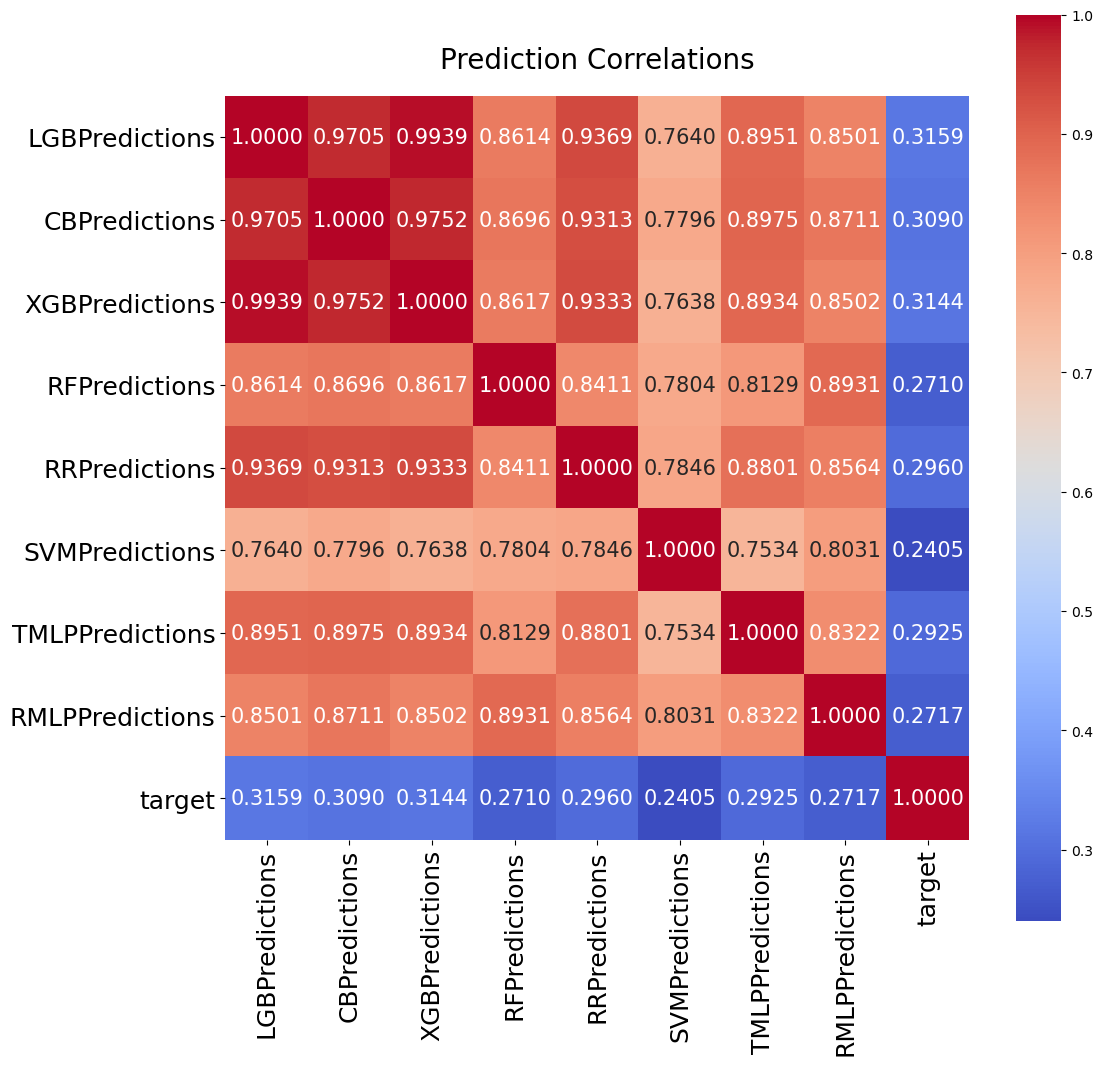

In [18]:
prediction_columns = [col for col in df_train_processed.columns if col.endswith('Predictions')]

fig = plt.figure(figsize=(12, 12), dpi=100)
sns.heatmap(df_train_processed[prediction_columns + [target]].corr(),
            annot=True,
            square=True,
            cmap='coolwarm',
            annot_kws={'size': 15},
            fmt='.4f')

plt.tick_params(axis='x', labelsize=18, rotation=90)
plt.tick_params(axis='y', labelsize=18, rotation=0)
plt.title('Prediction Correlations', size=20, pad=20)

plt.show()

In [19]:
class SubmissionPipeline:
    
    def __init__(self, train, test, blend, prediction_columns, add_public_best):
        
        self.train = train
        self.test = test
        self.blend = blend
        self.prediction_columns = prediction_columns
        self.add_public_best = add_public_best
        
    def weighted_average(self):
        
        self.train['FinalPredictions'] = (0.77 * self.train['LGBPredictions']) +\
                                         (0.04 * self.train['CBPredictions']) +\
                                         (0.06 * self.train['XGBPredictions']) +\
                                         (0.0 * self.train['RFPredictions']) +\
                                         (0.0 * self.train['RRPredictions']) +\
                                         (0.0 * self.train['SVMPredictions']) +\
                                         (0.12 * self.train['TMLPPredictions']) +\
                                         (0.01 * self.train['RMLPPredictions'])
        
        self.test['FinalPredictions'] = (0.77 * self.test['LGBPredictions']) +\
                                        (0.04 * self.test['CBPredictions']) +\
                                        (0.06 * self.test['XGBPredictions']) +\
                                        (0.0 * self.test['RFPredictions']) +\
                                        (0.0 * self.test['RRPredictions']) +\
                                        (0.0 * self.test['SVMPredictions']) +\
                                        (0.12 * self.test['TMLPPredictions']) +\
                                        (0.01 * self.test['RMLPPredictions'])
        
    def geometric_average(self):
        
        self.train['FinalPredictions'] = gmean(self.train[self.prediction_columns], axis=1)
        self.test['FinalPredictions'] = gmean(self.test[self.prediction_columns], axis=1)
        
    def weighted_average_public(self):
        
        public_best = pd.read_csv('../input/h2o-machine-learning/submission.csv')
        self.test['FinalPredictions'] = (self.test['FinalPredictions'] * 0.02) + (public_best['target'] * 0.98) 
        
    def transform(self):
        
        if self.blend == 'weighted_average':
            self.weighted_average()
        elif self.blend == 'geometric_average':
            self.geometric_average()
            
        for prediction_column in prediction_columns:
            oof_score = mean_squared_error(self.train[target], df_train_processed[prediction_column], squared=False)
            print(f'{prediction_column.split("Predictions")[0]} OOF RMSE: {oof_score:.6}')
        final_oof_score = mean_squared_error(self.train[target], df_train_processed['FinalPredictions'], squared=False)
        print(f'{"-" * 30}\nFinal OOF RMSE: {final_oof_score:.6}\n{"-" * 30}')
                
        if self.add_public_best:
            self.weighted_average_public()
                
        return self.train[['id'] + self.prediction_columns + ['FinalPredictions']].copy(deep=True), self.test[['id'] + self.prediction_columns + ['FinalPredictions']].copy(deep=True)
            


submission_pipeline = SubmissionPipeline(train=df_train_processed, test=df_test_processed,
                                         blend='weighted_average', prediction_columns=prediction_columns, add_public_best=True)   
df_train_submission, df_test_submission = submission_pipeline.transform()

LGB OOF RMSE: 0.695387
CB OOF RMSE: 0.697037
XGB OOF RMSE: 0.695752
RF OOF RMSE: 0.706454
RR OOF RMSE: 0.700054
SVM OOF RMSE: 0.714877
TMLP OOF RMSE: 0.700986
RMLP OOF RMSE: 0.705433
------------------------------
Final OOF RMSE: 0.695244
------------------------------


In [20]:
df_test_processed['target'] = df_test_submission['FinalPredictions']
df_test_processed[['id', 'target']].to_csv('submission.csv', index=False)
df_test_processed[['id', 'target']].describe()

id         target
count  200000.000000  200000.000000
mean   250261.031215       7.907793
std    144128.894365       0.228611
min         0.000000       7.059944
25%    125538.250000       7.750857
50%    250389.500000       7.898551
75%    375240.250000       8.051289
max    499990.000000       9.470155